# Report

## Introduction and data

Der Profifußball ist nicht nur eine der weltweit populärsten Sportarten, sondern auch ein komplexes globales Wirtschaftsphänomen. Spielertransfers und die damit verbundenen Marktwerte von Profifußballern stellen zentrale Elemente dar, die sowohl für Vereine als auch für Investoren von entscheidender Bedeutung sind. Die Frage, wie der Marktwert eines Spielers bestimmt wird und welche Faktoren darauf einwirken, ist sowohl für die Sportökonomie als auch für datenwissenschaftliche Forschungen von großem Interesse.
Die Bewertung von Spielerleistungen und das Ermitteln ihrer finanziellen Wertigkeit ist jedoch keine triviale Aufgabe. Sie umfasst zahlreiche Variablen, darunter individuelle Leistungsdaten, Alter, Position, Verletzungshistorie, internationale Erfahrung sowie die Dynamik des Transfermarktes. 
Das Ziel dieses Projekts ist es, die zentralen Faktoren zu identifizieren, die den Marktwert eines Spielers beeinflussen, und ein Modell zu entwickeln, das auf Basis dieser Erkenntnisse Marktwerte mit hoher Genauigkeit vorhersagen kann. Hierbei kommen historische Daten, statistische Analysen und moderne Verfahren des maschinellen Lernens zum Einsatz

**Wissenschaftliche Relevanz**

Die Erforschung von Marktwertvorhersagen im Profifußball verbindet wissenschaftliche Disziplinen wie Statistik, Ökonomie, Informatik und Sportwissenschaft. Neben der Verbesserung von Entscheidungsprozessen für Vereine und Scouts bietet diese Arbeit auch wertvolle Erkenntnisse über die Mechanismen und Dynamiken eines der lukrativsten Sportmärkte der Welt.

**Hypothese**: Der Marktwert eines Profifußballspielers kann mithilfe eines Baumdiagramm approximiert werden, wenn Variablen wie individuelle Leistungsdaten, physische Eigenschaften, Alter, Markttrends und Transferhistorien systematisch analysiert und in ein maschinelles Lernmodell integriert werden.


**Daten**: Diese Daten stammen aus kaggle die wiederum die Daten aus der bekannten Seite Transfermarkt.com abfragt. Die Datensätze werden aus kaggle heruntergeladen. 
Der Datensatz beinhaltet 10 .csv Dateien, die alle miteinander verknüpt sind.
Der Ersteller baute durch eine API eine Pipeline somit die Daten wöchentlich aktualisiert werden. Dadurch beinhalten die Datensätze immer die neuesten Daten und wird bei jeder neuen kompletten Ausführung des Notebooks auch aktualisiert. 
Quelle: https://www.kaggle.com/datasets/davidcariboo/player-scores

Die relevanten Datensätze werden im Notebook data/data-load.ipynb geladen und als parquet in data/raw gespeichert.

### Setup

In [2]:
import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import plotly.express as px
import plotly.io as pio

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import joblib
#import vegafusion as vf

In [3]:
pd.set_option('display.max_columns', None) 

### Import data

In [4]:
appearances = pd.read_parquet("../data/raw/appearances.parquet")
player_valuations = pd.read_parquet("../data/raw/player_valuations.parquet")
transfers = pd.read_parquet("../data/raw/transfers.parquet")
players = pd.read_parquet("../data/raw/players.parquet")

### Data structure

In [5]:
print("Appearances columns: \n", appearances.columns)
print("\n Player Valuations columns: \n", player_valuations.columns)
print("\n Transfers columns: \n", transfers.columns)
print("\n Players columns: \n", players.columns)

Appearances columns: 
 Index(['appearance_id', 'game_id', 'player_id', 'player_club_id',
       'player_current_club_id', 'date', 'player_name', 'competition_id',
       'yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played'],
      dtype='object')

 Player Valuations columns: 
 Index(['player_id', 'date', 'market_value_in_eur', 'current_club_id',
       'player_club_domestic_competition_id'],
      dtype='object')

 Transfers columns: 
 Index(['player_id', 'transfer_date', 'transfer_season', 'from_club_id',
       'to_club_id', 'from_club_name', 'to_club_name', 'transfer_fee',
       'market_value_in_eur', 'player_name'],
      dtype='object')

 Players columns: 
 Index(['player_id', 'first_name', 'last_name', 'name', 'last_season',
       'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth',
       'country_of_citizenship', 'date_of_birth', 'sub_position', 'position',
       'foot', 'height_in_cm', 'contract_expiration_date', 'agent_name',
       'image_ur

#### Appearances DataFrame
 **Beschreibung:** Diese Tabelle enthält historische Daten über die Leistungen eines Spielers in einzelnen Spielen.
 **Wichtige Spalten:**
 - `player_id`: Eindeutige Spieler-ID.
 - `date`: Datum des Spiels.
 - `player_name`: Name des Spielers.
 - `competition_id`: ID des Wettbewerbs.
 - `yellow_cards`, `red_cards`: Anzahl gelber und roter Karten.
 - `goals`, `assists`: Tore und Vorlagen im Spiel.
 - `minutes_played`: Anzahl der gespielten Minuten.

In [6]:
appearances.head(2)

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,CLQ,0,0,2,0,90
1,2233748_79232,2233748,79232,8841,2698,2012-07-05,Ruslan Abyshov,ELQ,0,0,0,0,90


#### Player Valuations DataFrame
 **Beschreibung:** Diese Tabelle zeigt die Marktwertentwicklungen der Spieler über die Zeit.
 **Wichtige Spalten:**
 - `player_id`: Eindeutige Spieler-ID.
 - `date`: Datum der Marktwertermittlung.
 - `market_value_in_eur`: Erster Marktwert in Euro.
 - `current_club_id`: ID des aktuellen Clubs.
 - `player_club_domestic_competition_id`: ID des nationalen Wettbewerbs des aktuellen Clubs.


In [7]:
player_valuations.head(2)

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
0,405973,2000-01-20,150000,3057,BE1
1,342216,2001-07-20,100000,1241,SC1


#### Transfers DataFrame
 **Beschreibung:** Diese Tabelle enthält Informationen zu Spielertransfers zwischen Clubs.
 **Wichtige Spalten:**
 - `player_id`: Eindeutige Spieler-ID.
 - `transfer_date`: Datum des Transfers.
 - `transfer_season`: Saison des Transfers.
 - `from_club_id`, `to_club_id`: IDs des abgebenden und aufnehmenden Clubs.
 - `from_club_name`, `to_club_name`: Namen der Clubs.
 - `transfer_fee`: Transfergebühr in Euro.
 - `market_value_in_eur`: Marktwert des Spielers zum Zeitpunkt des Transfers.

In [8]:
transfers.head(2)

,player_id,transfer_date,transfer_season,from_club_id,to_club_id,from_club_name,to_club_name,transfer_fee,market_value_in_eur,player_name
0,195778,2026-06-30,25/26,79,27,VfB Stuttgart,Bayern Munich,0.0,12000000.0,Alexander Nübel
1,569033,2026-06-30,25/26,39,27,1.FSV Mainz 05,Bayern Munich,0.0,4000000.0,Armindo Sieb


#### Players DataFrame
 **Beschreibung:** Diese Tabelle enthält Basisinformationen zu Spielern.
 **Wichtige Spalten:**
 - `player_id`: Eindeutige Spieler-ID.
 - `name`, `first_name`, `last_name`: Name des Spielers.
 - `country_of_birth`, `country_of_citizenship`: Geburtsland und Staatsangehörigkeit.
 - `foot`: Bevorzugter Fuß (rechts/links).
 - `height_in_cm`: Körpergröße in cm.
 - `contract_expiration_date`: Vertragslaufzeitende.
 - `current_club_name`: Name des aktuellen Clubs.
 - `market_value_in_eur`: Aktueller Marktwert in Euro.
 - `highest_market_value_in_eur`: Höchster Marktwert in Euro.

In [9]:
players.head(2)

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
0,10,Miroslav,Klose,Miroslav Klose,2015,398,miroslav-klose,Poland,Opole,Germany,1978-06-09 00:00:00,Centre-Forward,Attack,right,184.0,None,ASBW Sport Marketing,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/miroslav-klose...,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0
1,26,Roman,Weidenfeller,Roman Weidenfeller,2017,16,roman-weidenfeller,Germany,Diez,Germany,1980-08-06 00:00:00,Goalkeeper,Goalkeeper,left,190.0,None,Neubauer 13 GmbH,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/roman-weidenfe...,L1,Borussia Dortmund,750000.0,8000000.0


### Data corrections

#### Aggregierte Appearances DataFrame
- **Beschreibung:** Diese Tabelle fasst die Leistungen eines Spielers über alle Spiele zusammen.
- **Aggregierte Spalten:**
  - `total_minutes_played`: Gesamte Spielminuten.
  - `total_goals`, `total_assists`: Gesamte Tore und Vorlagen.
  - `total_yellow_cards`, `total_red_cards`: Summe der gelben und roten Karten.
  - `total_golas_per_game`: Totaler Durchschnitt der Tore pro Spiel 


In [10]:
appearances_agg = appearances.groupby('player_id').agg({
    'minutes_played': 'sum',  # Gesamtminuten
    'goals': 'sum',           # Gesamttore
    'assists': 'sum',         # Gesamtvorlagen
    'yellow_cards': 'sum',    # Gelbe Karten
    'red_cards': 'sum',       # Rote Karten
    'game_id': 'count'        # Anzahl der Spiele
}).reset_index()

appearances_agg.rename(columns={
    'minutes_played': 'total_minutes_played',
    'goals': 'total_goals',
    'assists': 'total_assists',
    'yellow_cards': 'total_yellow_cards',
    'red_cards': 'total_red_cards',
    'game_id': 'total_matches'
}, inplace=True)


appearances_agg.head()

,player_id,total_minutes_played,total_goals,total_assists,total_yellow_cards,total_red_cards,total_matches
0,10,8808,48,25,19,0,136
1,26,13508,0,0,4,2,152
2,65,8788,38,13,11,1,122
3,77,307,0,0,0,0,4
4,80,1080,0,0,0,0,12


#### Aggregierte Appearancespro Jahr (historisiert)
- **Beschreibung:** Diese Tabelle fasst die Leistung jährlich eines Spielers über alle Spiele zusammen.
- **Aggregierte Spalten:**
  - `minutes_played_per_game`: Gesamte Spielminuten.
  - `assists_per_game`: Gesamte Vorlagen.
  - `yellow_cards_per_game`, `red_cards_per_game`: Summe der gelben und roten Karten.
  - `golas_per_game`: Totaler Durchschnitt der Tore pro Spiel 


In [11]:
appearances['date'] = pd.to_datetime(appearances['date'])
appearances['year'] = appearances['date'].dt.year

appearances_hist = appearances.groupby(['player_id', 'year']).agg({
    'minutes_played': 'sum',
    'goals': 'sum',         
    'assists': 'sum',       
    'yellow_cards': 'sum',  
    'red_cards': 'sum',     
    'game_id': 'count' 
}).reset_index()

appearances_hist['goals_per_game'] = appearances_hist['goals'] / appearances_hist['game_id']
appearances_hist['assists_per_game'] = appearances_hist['assists'] / appearances_hist['game_id']
appearances_hist['yellow_cards_per_game'] = appearances_hist['yellow_cards'] / appearances_hist['game_id']
appearances_hist['red_cards_per_game'] = appearances_hist['red_cards'] / appearances_hist['game_id']
appearances_hist['minutes_played_per_game'] = appearances_hist['minutes_played'] / appearances_hist['game_id']

appearances_hist.drop(["minutes_played", "goals", "assists", "yellow_cards", "red_cards", "game_id"], axis=1, inplace =True)

appearances_hist.head()

,player_id,year,goals_per_game,assists_per_game,yellow_cards_per_game,red_cards_per_game,minutes_played_per_game
0,10,2012,0.550000,0.050000,0.300000,0.0,74.150000
1,10,2013,0.310345,0.137931,0.103448,0.0,70.758621
2,10,2014,0.258065,0.193548,0.096774,0.0,56.967742
3,10,2015,0.333333,0.222222,0.166667,0.0,67.472222
4,10,2016,0.400000,0.300000,0.050000,0.0,53.900000


In diesem Schritt werden die Leistungsdaten der Spieler, wie Tore, Assists und Karten, auf Spielebene normalisiert, um Metriken wie `goals_per_game` oder `assists_per_game` zu berechnen. Dadurch wird die Leistung unabhängig von der Anzahl absolvierter Spiele dargestellt, was eine objektivere Analyse ermöglicht und zeitliche Entwicklungen präziser abbildet. Dies erlaubt eine differenziertere Analyse, die weniger von der Anzahl der absolvierten Spiele beeinflusst ist.

In [12]:
player_data = appearances_hist[appearances_hist['player_id'] == 342229]
fig = px.line(
    player_data,
    x='year',
    y='goals_per_game',
    title='Tore pro Spiel im Zeitverlauf',
    labels={'goals_per_game': 'Tore pro Spiel', 'year': 'Jahr'}
)
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        tick0=min(player_data['year']),
        dtick=1  # Schritte von 1 Jahr
    )
)
#speichern
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

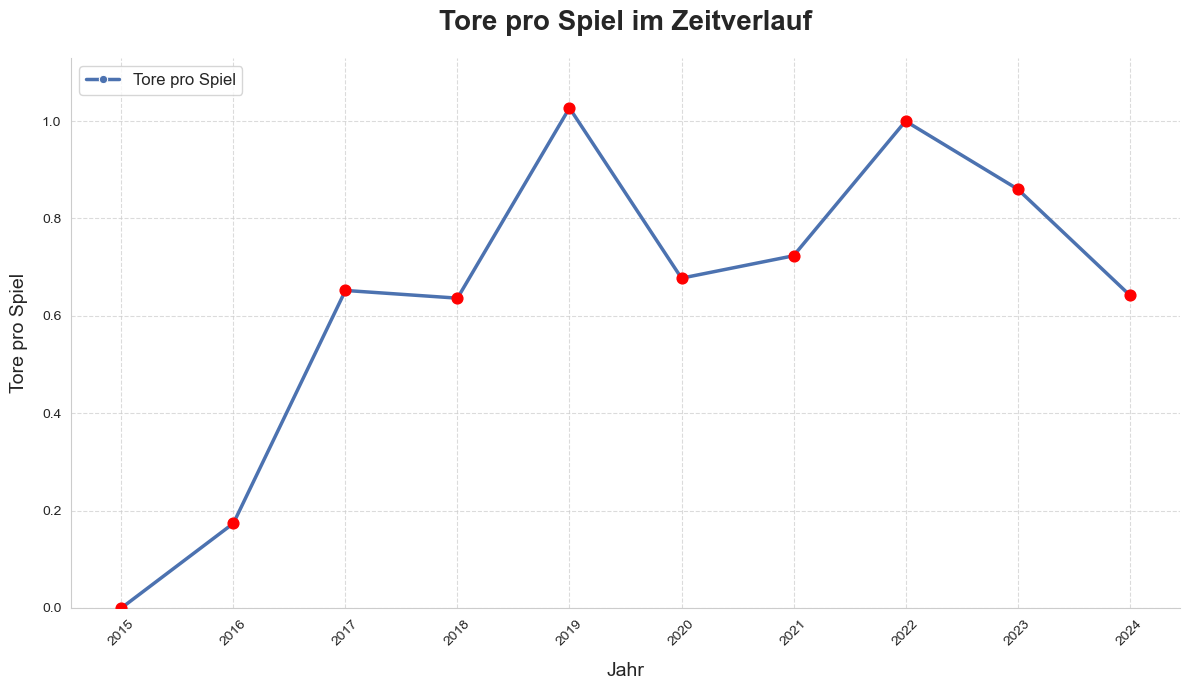

In [13]:
sns.set_style("whitegrid")
sns.set_palette("deep")

player_data = appearances_hist[appearances_hist['player_id'] == 342229]

plt.figure(figsize=(12, 7))

sns.lineplot(data=player_data, x='year', y='goals_per_game', linewidth=2.5, marker='o')
plt.scatter(player_data['year'], player_data['goals_per_game'], s=60, color='red', zorder=5)

plt.title('Tore pro Spiel im Zeitverlauf', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Jahr', fontsize=14, labelpad=10)
plt.ylabel('Tore pro Spiel', fontsize=14, labelpad=10)

plt.xticks(range(min(player_data['year']), max(player_data['year'])+1, 1), rotation=45)
plt.ylim(0, max(player_data['goals_per_game']) * 1.1)
plt.grid(True, linestyle='--', alpha=0.7)
sns.despine()
plt.legend(['Tore pro Spiel'], loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()



Die Grafik zeigt der Verlauf von Toren pro Spiel des Topspielers Kylian Mbappe.

#### Fehldende Werte raussuchen und Daten Engineering

In [14]:
print("Fehlende Werte in appearances:")
print(appearances.isnull().sum())

Fehlende Werte in appearances:
appearance_id             0
game_id                   0
player_id                 0
player_club_id            0
player_current_club_id    0
date                      0
player_name               6
competition_id            0
yellow_cards              0
red_cards                 0
goals                     0
assists                   0
minutes_played            0
year                      0
dtype: int64


In [15]:
print("Fehlende Werte in player_valuations:")
player_valuations['date'] = pd.to_datetime(player_valuations['date'])
player_valuations['year'] = player_valuations['date'].dt.year

#player_valuations.drop("date", axis=1, inplace=True) # date wird gelöscht um auf Jahreseben den Marktwert zu untersuchen
player_valuations = player_valuations.drop_duplicates(subset=['player_id','year'], keep='last') # damit wird gewährleistet, dass pro Jahr auf nur ein Marktwert pro Spieler limitiert wird
print(player_valuations.isnull().sum())

Fehlende Werte in player_valuations:
player_id                              0
date                                   0
market_value_in_eur                    0
current_club_id                        0
player_club_domestic_competition_id    0
year                                   0
dtype: int64


Durch `drop_duplicates(subset=['player_id','year'], keep='last')` wird gewährleistet, dass es auf nur ein Marktwert pro Spieler im Jahr limitiert wird. Da es Spieler gibt deren Marktwert mehrmals im Jahr abgefragt wird.

In [16]:
print("Fehlende Werte in transfers:")
transfers['transfer_date'] = pd.to_datetime(transfers['transfer_date'])
transfers['year'] = transfers['transfer_date'].dt.year
# wichtig für das Mergen später
print(transfers.isnull().sum())

Fehlende Werte in transfers:
player_id                  0
transfer_date              0
transfer_season            0
from_club_id               0
to_club_id                 0
from_club_name             0
to_club_name               0
transfer_fee           27262
market_value_in_eur    29783
player_name                0
year                       0
dtype: int64


In [17]:
print("Fehlende Werte in players:")

print(players.isnull().sum())

Fehlende Werte in players:
player_id                                   0
first_name                               2060
last_name                                   0
name                                        0
last_season                                 0
current_club_id                             0
player_code                                 0
country_of_birth                         2804
city_of_birth                            2464
country_of_citizenship                    380
date_of_birth                              47
sub_position                              183
position                                    0
foot                                     2568
height_in_cm                             2303
contract_expiration_date                12111
agent_name                              15986
image_url                                   0
url                                         0
current_club_domestic_competition_id        0
current_club_name                           0
market_

In [18]:
players.dropna(subset=['market_value_in_eur'], inplace=True)

In [19]:
print("Fehlende Werte in appearances_hist:")
print(appearances_hist.isnull().sum())

Fehlende Werte in appearances_hist:
player_id                  0
year                       0
goals_per_game             0
assists_per_game           0
yellow_cards_per_game      0
red_cards_per_game         0
minutes_played_per_game    0
dtype: int64


#### Merging Datasets

`combined_data_agg` enthält die aggregierte Version (`appearances_agg`) der Spieler. Keine Historie enthalten durch `drop_duplicates(subset='player_id', keep='last')` wird der aktuellste Marktewert genommen.

In [20]:
combined_data_agg = players.merge(appearances_agg, on='player_id', how='inner')

#combined_data_agg = combined_data_agg.merge(transfers[['player_id', 'transfer_fee', 'market_value_in_eur','year']].drop_duplicates(subset='player_id', keep='first'), 
#                                    on=['player_id'], how='left')

combined_data_agg.head()

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur,total_minutes_played,total_goals,total_assists,total_yellow_cards,total_red_cards,total_matches
0,10,Miroslav,Klose,Miroslav Klose,2015,398,miroslav-klose,Poland,Opole,Germany,1978-06-09 00:00:00,Centre-Forward,Attack,right,184.0,None,ASBW Sport Marketing,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/miroslav-klose...,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0,8808,48,25,19,0,136
1,26,Roman,Weidenfeller,Roman Weidenfeller,2017,16,roman-weidenfeller,Germany,Diez,Germany,1980-08-06 00:00:00,Goalkeeper,Goalkeeper,left,190.0,None,Neubauer 13 GmbH,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/roman-weidenfe...,L1,Borussia Dortmund,750000.0,8000000.0,13508,0,0,4,2,152
2,65,Dimitar,Berbatov,Dimitar Berbatov,2015,1091,dimitar-berbatov,Bulgaria,Blagoevgrad,Bulgaria,1981-01-30 00:00:00,Centre-Forward,Attack,None,NaN,None,CSKA-AS-23 Ltd.,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/dimitar-berbat...,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.0,34500000.0,8788,38,13,11,1,122
3,77,None,Lúcio,Lúcio,2012,506,lucio,Brazil,Brasília,Brazil,1978-05-08 00:00:00,Centre-Back,Defender,None,NaN,None,None,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lucio/profil/s...,IT1,Juventus Football Club,200000.0,24500000.0,307,0,0,0,0,4
4,80,Tom,Starke,Tom Starke,2017,27,tom-starke,East Germany (GDR),Freital,Germany,1981-03-18 00:00:00,Goalkeeper,Goalkeeper,right,194.0,None,IFM,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/tom-starke/pro...,L1,FC Bayern München,100000.0,3000000.0,1080,0,0,0,0,12


In [21]:
combined_data_agg[combined_data_agg["name"]=="Kylian Mbappé"]

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur,total_minutes_played,total_goals,total_assists,total_yellow_cards,total_red_cards,total_matches
16243,342229,Kylian,Mbappé,Kylian Mbappé,2024,418,kylian-mbappe,France,Paris,France,1998-12-20 00:00:00,Centre-Forward,Attack,right,178.0,2029-06-30 00:00:00,None,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/kylian-mbappe/...,ES1,Real Madrid Club de Fútbol,180000000.0,200000000.0,26230,253,103,45,1,346


`combined_data_hist` enthält die historisierte Version (`appearances_hist`) der Aggregationen 

In [22]:
combined_data_hist = player_valuations.merge(players, on='player_id', how='inner')
combined_data_hist = combined_data_hist.merge(appearances_hist, on=['player_id', 'year'], how='inner')

combined_data_hist = combined_data_hist.merge(transfers[['player_id', 'transfer_fee', 'market_value_in_eur', 'year', 'transfer_season']], 
                                    on=['player_id', 'year'] , how='left')

combined_data_hist.head()

,player_id,date,market_value_in_eur_x,current_club_id_x,player_club_domestic_competition_id,year,first_name,last_name,name,last_season,current_club_id_y,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur_y,highest_market_value_in_eur,goals_per_game,assists_per_game,yellow_cards_per_game,red_cards_per_game,minutes_played_per_game,transfer_fee,market_value_in_eur,transfer_season
0,21552,2012-01-01,250000,383,NL1,2012,Danny,Wintjens,Danny Wintjens,2014,383,danny-wintjens,Netherlands,Maastricht,Netherlands,1983-09-30 00:00:00,Goalkeeper,Goalkeeper,right,195.0,None,None,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/danny-wintjens...,NL1,Eindhovense Voetbalvereniging Philips Sport Ve...,150000.0,450000.0,0.000000,0.000000,0.000000,0.0,89.800000,NaN,NaN,NaN
1,34556,2012-01-01,500000,1426,NL1,2012,Arjan,Swinkels,Arjan Swinkels,2020,1426,arjan-swinkels,Netherlands,Moergestel,Netherlands,1984-10-15 00:00:00,Centre-Back,Defender,left,184.0,None,None,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/arjan-swinkels...,NL1,VVV-Venlo,125000.0,700000.0,0.000000,0.000000,0.000000,0.0,90.000000,NaN,NaN,NaN
2,41583,2012-01-01,250000,1269,NL1,2012,Bram,van Polen,Bram van Polen,2023,1269,bram-van-polen,Netherlands,Nijkerk,Netherlands,1985-10-11 00:00:00,Right-Back,Defender,right,179.0,None,None,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/bram-van-polen...,NL1,Prins Hendrik Ende Desespereert Nimmer Combina...,100000.0,1000000.0,0.000000,0.050000,0.250000,0.0,91.500000,NaN,NaN,NaN
3,56438,2012-01-01,150000,403,NL1,2012,Ruud,van der Rijt,Ruud van der Rijt,2012,403,ruud-van-der-rijt,Netherlands,Nijnsel,Netherlands,1988-11-17 00:00:00,Centre-Back,Defender,right,185.0,None,None,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/ruud-van-der-r...,NL1,Willem II,200000.0,200000.0,0.000000,0.000000,0.400000,0.0,85.600000,NaN,NaN,NaN
4,83946,2012-01-01,250000,1268,NL1,2012,Youness,Mokhtar,Youness Mokhtar,2020,1268,youness-mokhtar,Netherlands,Utrecht,Morocco,1991-08-29 00:00:00,Left Winger,Attack,right,178.0,2023-06-30 00:00:00,None,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/youness-mokhta...,NL1,ADO Den Haag,300000.0,2500000.0,0.263158,0.052632,0.052632,0.0,81.315789,NaN,NaN,NaN


#### Feature Engineering

In [23]:
combined_data_hist.rename(columns={
    'market_value_in_eur_x': 'historical_to_date__market_value',
    'market_value_in_eur_y': 'current_market_value',
    'market_value_in_eur': 'transfer_market_value',
    'player_club_domestic_competition_id': 'league_id'
}, inplace=True)

combined_data_agg.rename(columns={
    'market_value_in_eur': 'current_market_value',
    'current_club_domestic_competition_id': 'league_id'
}, inplace=True)

In [24]:
## Feautre Engineering: transfer gap
combined_data_hist['transfer_fee_gap'] = combined_data_hist['transfer_fee'] - combined_data_hist['transfer_market_value']
combined_data_hist.drop(columns=['current_club_id_x', 'current_club_id_y', 'image_url', 'url', 'agent_name', 'player_code', 'first_name', 'last_name', 'current_club_domestic_competition_id'], inplace=True)

In [25]:
combined_data_agg.drop(columns=['image_url', 'url', 'agent_name', 'player_code', 'first_name', 'last_name'], inplace=True)

`transfer_fee_gap` enthält die Differenz zwischen der Transfer Gebühr und den jeweiligen Marktwert im Jahr des Transfers. Da die Transfers jährlich vorliegen, werden der `transfer_fee_gap` nur bei der historischen Version hinzugefügt 

##### Alter ergänzen und evaluieren

In [26]:
## Feautre Engineering: Alter
combined_data_hist['age'] = (pd.to_datetime(combined_data_hist['date']).dt.year - 
                         pd.to_datetime(combined_data_hist['date_of_birth']).dt.year)

current_year = datetime.now().year
combined_data_agg['age'] = current_year - pd.to_datetime(combined_data_agg['date_of_birth']).dt.year


In [27]:
combined_data_hist[['date_of_birth', 'age']].head()

,date_of_birth,age
0,1983-09-30 00:00:00,29.0
1,1984-10-15 00:00:00,28.0
2,1985-10-11 00:00:00,27.0
3,1988-11-17 00:00:00,24.0
4,1991-08-29 00:00:00,21.0


In [28]:
combined_data_agg.head(2)

,player_id,name,last_season,current_club_id,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,league_id,current_club_name,current_market_value,highest_market_value_in_eur,total_minutes_played,total_goals,total_assists,total_yellow_cards,total_red_cards,total_matches,age
0,10,Miroslav Klose,2015,398,Poland,Opole,Germany,1978-06-09 00:00:00,Centre-Forward,Attack,right,184.0,None,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0,8808,48,25,19,0,136,47.0
1,26,Roman Weidenfeller,2017,16,Germany,Diez,Germany,1980-08-06 00:00:00,Goalkeeper,Goalkeeper,left,190.0,None,L1,Borussia Dortmund,750000.0,8000000.0,13508,0,0,4,2,152,45.0


In [29]:
combined_data_hist.head(2)

,player_id,date,historical_to_date__market_value,league_id,year,name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,current_club_name,current_market_value,highest_market_value_in_eur,goals_per_game,assists_per_game,yellow_cards_per_game,red_cards_per_game,minutes_played_per_game,transfer_fee,transfer_market_value,transfer_season,transfer_fee_gap,age
0,21552,2012-01-01,250000,NL1,2012,Danny Wintjens,2014,Netherlands,Maastricht,Netherlands,1983-09-30 00:00:00,Goalkeeper,Goalkeeper,right,195.0,None,Eindhovense Voetbalvereniging Philips Sport Ve...,150000.0,450000.0,0.0,0.0,0.0,0.0,89.8,NaN,NaN,NaN,NaN,29.0
1,34556,2012-01-01,500000,NL1,2012,Arjan Swinkels,2020,Netherlands,Moergestel,Netherlands,1984-10-15 00:00:00,Centre-Back,Defender,left,184.0,None,VVV-Venlo,125000.0,700000.0,0.0,0.0,0.0,0.0,90.0,NaN,NaN,NaN,NaN,28.0


In [30]:
combined_data_hist = combined_data_hist[combined_data_hist['age'] > 15]
combined_data_agg = combined_data_agg[combined_data_agg['age'] > 15]

combined_data_hist.shape

(105063, 29)

In diesem Schritt wird das Alter der Spieler zum Zeitpunkt der Marktwertbewertung berechnet, indem das Datum der Bewertung (`date`) und das Geburtsdatum des Spielers (`date_of_birth`) herangezogen werden. Anschließend wird der Datensatz gefiltert, sodass nur Spieler berücksichtigt werden, die zum Zeitpunkt der Bewertung ein Mindestalter von 15 Jahren erreicht haben.

Das Mindestalter von 15 Jahren wird als Untergrenze definiert, da Marktwertbewertungen für Spieler, die jünger als 15 Jahre alt sind, in der Regel unplausibel und fehlerhaft erscheinen. Solche Datensätze können als Ausreißer betrachtet werden und die statistische Analyse sowie die Vorhersagemodelle erheblich verfälschen.

##### Aktive oder in Rente 

In [31]:
current_year = 2025

combined_data_hist['is_retired'] = combined_data_hist['last_season'] <= (current_year - 5)

combined_data_agg['is_retired'] = combined_data_agg['last_season'] <= (current_year - 5)

Die neue  Variable `is_retired` erlaubt es, aktive und inaktive Spieler getrennt zu betrachten, was Verzerrungen in den Modellen reduzieren kann.

#### Change Datatypes

In [32]:
combined_data_hist.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105063 entries, 0 to 105127
Data columns (total 30 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   player_id                         105063 non-null  int64         
 1   date                              105063 non-null  datetime64[ns]
 2   historical_to_date__market_value  105063 non-null  int64         
 3   league_id                         105063 non-null  object        
 4   year                              105063 non-null  int32         
 5   name                              105063 non-null  object        
 6   last_season                       105063 non-null  int64         
 7   country_of_birth                  101334 non-null  object        
 8   city_of_birth                     102672 non-null  object        
 9   country_of_citizenship            103701 non-null  object        
 10  date_of_birth                     105

In [33]:
# IDs zu Strings umwandeln
id_columns = [
    "player_id", "league_id"
]
combined_data_hist[id_columns] = combined_data_hist[id_columns].astype(str)

# Datumsangaben umwandeln
date_columns = ["date", "date_of_birth", "contract_expiration_date"]
for col in date_columns:
    combined_data_hist[col] = pd.to_datetime(combined_data_hist[col], errors='coerce')


print(combined_data_hist.info())


<class 'pandas.core.frame.DataFrame'>
Index: 105063 entries, 0 to 105127
Data columns (total 30 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   player_id                         105063 non-null  object        
 1   date                              105063 non-null  datetime64[ns]
 2   historical_to_date__market_value  105063 non-null  int64         
 3   league_id                         105063 non-null  object        
 4   year                              105063 non-null  int32         
 5   name                              105063 non-null  object        
 6   last_season                       105063 non-null  int64         
 7   country_of_birth                  101334 non-null  object        
 8   city_of_birth                     102672 non-null  object        
 9   country_of_citizenship            103701 non-null  object        
 10  date_of_birth                     105

In [34]:
combined_data_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25082 entries, 0 to 25101
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player_id                    25082 non-null  int64  
 1   name                         25082 non-null  object 
 2   last_season                  25082 non-null  int64  
 3   current_club_id              25082 non-null  int64  
 4   country_of_birth             23760 non-null  object 
 5   city_of_birth                24037 non-null  object 
 6   country_of_citizenship       24790 non-null  object 
 7   date_of_birth                25082 non-null  object 
 8   sub_position                 25019 non-null  object 
 9   position                     25082 non-null  object 
 10  foot                         24041 non-null  object 
 11  height_in_cm                 24321 non-null  float64
 12  contract_expiration_date     16118 non-null  object 
 13  league_id            

In [35]:
# IDs zu Strings umwandeln
id_columns = [
    "player_id", "current_club_id", "league_id"
]
combined_data_agg[id_columns] = combined_data_agg[id_columns].astype(str)

# Datumsangaben umwandeln
date_columns = [ "date_of_birth", "contract_expiration_date"]
for col in date_columns:
    combined_data_agg[col] = pd.to_datetime(combined_data_agg[col], errors='coerce')


print(combined_data_agg.info())

<class 'pandas.core.frame.DataFrame'>
Index: 25082 entries, 0 to 25101
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   player_id                    25082 non-null  object        
 1   name                         25082 non-null  object        
 2   last_season                  25082 non-null  int64         
 3   current_club_id              25082 non-null  object        
 4   country_of_birth             23760 non-null  object        
 5   city_of_birth                24037 non-null  object        
 6   country_of_citizenship       24790 non-null  object        
 7   date_of_birth                25082 non-null  datetime64[ns]
 8   sub_position                 25019 non-null  object        
 9   position                     25082 non-null  object        
 10  foot                         24041 non-null  object        
 11  height_in_cm                 24321 non-null  f

In [36]:

# abspeichern in data/processed
combined_data_hist.to_parquet('../data/processed/combined_data_hist.parquet')
combined_data_agg.to_parquet('../data/processed/combined_data_agg.parquet')

### Analysis

Für die Analysen wird die aggregierte Version der Dataframes `combined_data_agg` genutzt, um das mehrfache Vorkommen von Spielern zu verhindern. 

In [81]:
fig = px.box(
    combined_data_agg, 
    y="current_market_value", 
    color=combined_data_agg['is_retired'].map({True: 'Retired', False: 'Active'}),
    title="02_Boxplot des aktuellen Marktwerts, aufgeteilt nach aktiven oder zurückgetretenen Spielern (2020)",
    labels={"current_market_value": "Marktwert (in M€)"},
    hover_data=["name", "age"] 
)

fig.update_layout(
    yaxis=dict(title="Marktwert (in M€)", showgrid=True),
    xaxis=dict(showticklabels=False),
    title=dict(x=0.5)  # Titel zentrieren
)

#fig.show()
#speichern
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

/var/folders/df/9tj0fbwx73g3tg845tnm3j480000gn/T/ipykernel_78191/4152679206.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




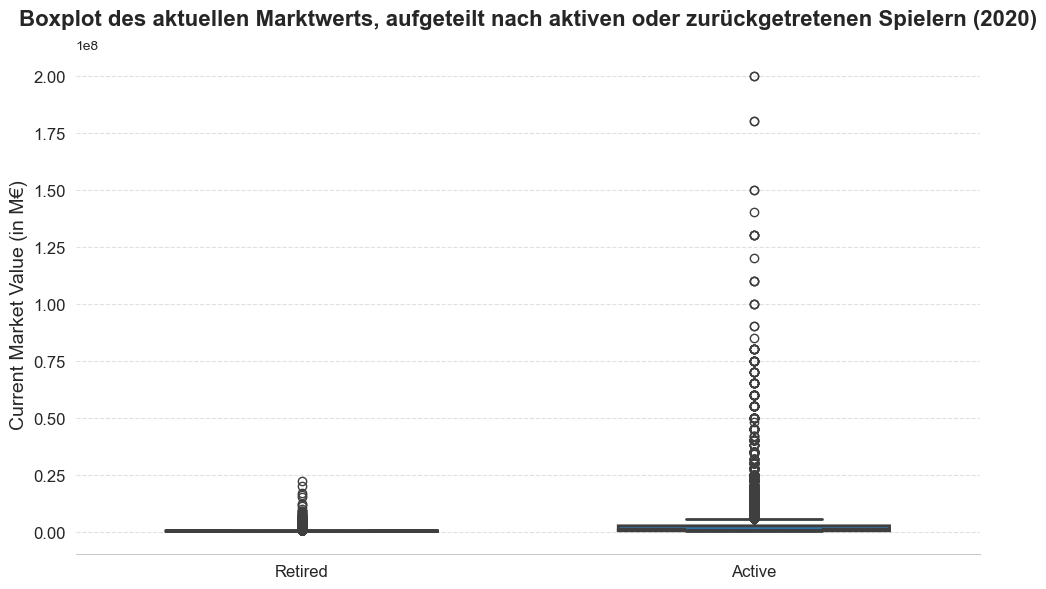

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=combined_data_agg,
    y="current_market_value",
    x=combined_data_agg['is_retired'].map({True: 'Retired', False: 'Active'}),
    palette={"Active": "#1f77b4", "Retired": "#d62728"},  # Blau für Active, Rot für Retired
    linewidth=2,
    width=0.6,
    notch=True
)

plt.title("Boxplot des aktuellen Marktwerts, aufgeteilt nach aktiven oder zurückgetretenen Spielern (2020)", fontsize=16, weight='bold', pad=20)
plt.ylabel("Current Market Value (in M€)", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True)

plt.tight_layout()
plt.show()

Die Boxplots zeigen die Verteilung der aktuellen Marktwerte von Fußballspielern, getrennt nach aktiven und pensionierten Spielern. Die Marktwerte konzentrieren sich überwiegend im unteren Bereich, wobei einige wenige aktive Spieler als Ausreißer deutlich höhere Werte aufweisen. Pensionierte Spieler haben insgesamt niedrigere Marktwerte und kaum Ausreißer, was auf eine homogenere Verteilung hinweist. Der Plot verdeutlicht die starke Schiefe der Marktwerte und die größere Streuung bei aktiven Spielern im Vergleich zu pensionierten.

#### Ohne Ausreißer

In [38]:
q1 = combined_data_agg["current_market_value"].quantile(0.25)
q3 = combined_data_agg["current_market_value"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filtern der Daten ohne Ausreißer
combined_data_agg_no_outliers = combined_data_agg[
    (combined_data_agg["current_market_value"] >= lower_bound) & 
    (combined_data_agg["current_market_value"] <= upper_bound)
]

In [39]:
combined_data_agg_no_outliers.shape

(21546, 25)

In [85]:
fig = px.box(
    combined_data_agg_no_outliers, 
    y="current_market_value", 
    title="03_Boxplot des aktuellen Marktwerts, aufgeteilt nach aktiven oder zurückgetretenen Spielern (2020), ohne Ausreißer",
    labels={"current_market_value": "Marktwert (in M€)"},
    hover_data=["name", "age"]
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

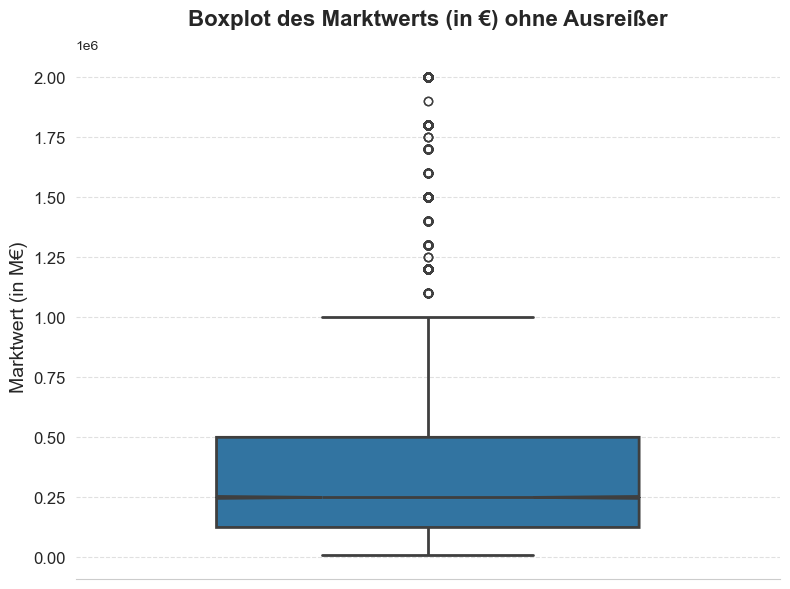

In [40]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=combined_data_agg_no_outliers,
    y="current_market_value",
    linewidth=2,
    width=0.6,
    color="#1f77b4",
    notch=True
)

plt.title("Boxplot des Marktwerts (in €) ohne Ausreißer", fontsize=16, weight='bold', pad=20)
plt.ylabel("Marktwert (in M€)", fontsize=14)
plt.xlabel("")
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True)

plt.tight_layout()
plt.show()

Nach dem Filtern der Außreiser sieht der Boyplot so aus. Dieser weißt einen Median von 0.25 Mil mit einem Upper Fence von einer Mil.

In [87]:
fig = px.box(
    combined_data_agg_no_outliers, 
    y="current_market_value", 
    color=combined_data_agg_no_outliers['is_retired'].map({True: 'Retired', False: 'Active'}),
    title="04_Boxplot des aktuellen Marktwerts, aufgeteilt nach aktiven oder zurückgetretenen Spielern (2020)",
    labels={"current_market_value": "Marktwert (in M€)"},
    hover_data=["name", "age"],
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

/var/folders/df/9tj0fbwx73g3tg845tnm3j480000gn/T/ipykernel_78191/2635168165.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




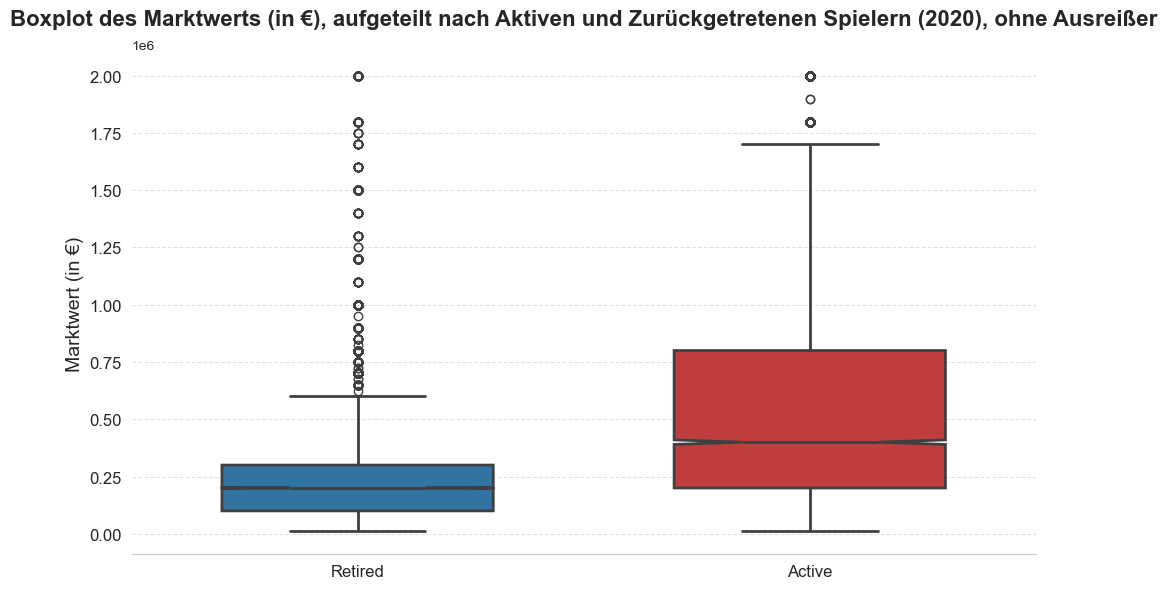

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=combined_data_agg_no_outliers,
    y="current_market_value",
    x=combined_data_agg_no_outliers['is_retired'].map({True: 'Retired', False: 'Active'}),
    palette={"Active": "#d62728", "Retired": "#1f77b4"},
    linewidth=2,
    width=0.6,
    notch=True
)

plt.title("Boxplot des Marktwerts (in €), aufgeteilt nach Aktiven und Zurückgetretenen Spielern (2020), ohne Ausreißer", fontsize=16, weight='bold', pad=20)
plt.ylabel("Marktwert (in €)", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True)

plt.tight_layout()
plt.show()

Die obere Grafik hier nochmals unterteilt nach Aktiven und zurückgetretnen Spielern.

#### Descriptive statistics

In [42]:
#combined_data.describe().T

numeric_combined_data_agg = combined_data_agg.select_dtypes(include=["number"])
numeric_combined_data_agg.describe().T

,count,mean,std,min,25%,50%,75%,max
last_season,25082.0,2.019600e+03,3.976432e+00,2012.0,2016.00,2020.0,2023.0,2024.0
height_in_cm,24321.0,1.820993e+02,6.819914e+00,18.0,178.00,182.0,187.0,207.0
current_market_value,25082.0,1.950160e+06,7.013315e+06,10000.0,150000.00,300000.0,900000.0,200000000.0
highest_market_value_in_eur,25082.0,4.475840e+06,1.057416e+07,10000.0,400000.00,1000000.0,3500000.0,200000000.0
total_minutes_played,25082.0,4.565377e+03,6.303755e+03,1.0,363.25,1907.0,6276.0,49595.0
total_goals,25082.0,6.335460e+00,1.676031e+01,0.0,0.00,1.0,5.0,490.0
total_assists,25082.0,4.989674e+00,1.114626e+01,0.0,0.00,1.0,5.0,224.0
total_yellow_cards,25082.0,9.755761e+00,1.470991e+01,0.0,1.00,4.0,13.0,147.0
total_red_cards,25082.0,2.495415e-01,6.170342e-01,0.0,0.00,0.0,0.0,8.0
total_matches,25082.0,6.599793e+01,8.385051e+01,1.0,8.00,32.0,93.0,589.0


Die deskriptive Analyse zeigt eine große Vielfalt unter den Fußballspielern, sowohl in Bezug auf ihre Leistung als auch auf ihren Marktwert. Der durchschnittliche aktuelle Marktwert (`current_market_value`) liegt bei etwa 1,95 Millionen Euro, wobei die Werte von nur 10.000 Euro bis hin zu beeindruckenden 200 Millionen Euro reichen. Spieler haben im Durchschnitt 6,33 Tore (`total_goals`) und 4,99 Assists (`total_assists`) erzielt, mit maximalen Werten von 490 Toren und 224 Assists, was die Präsenz einiger außergewöhnlicher Akteure unterstreicht. Die durchschnittliche Anzahl absolvierter Spiele (`total_matches`) liegt bei rund 66, wobei einige Spieler bis zu 589 Spiele bestritten haben. Die durchschnittliche Spielzeit (`total_minutes_played`) beläuft sich auf 4.565 Minuten, mit einem Maximum von nahezu 50.000 Minuten. Disziplinarisch erhalten Spieler im Schnitt etwa 9,76 gelbe Karten (`total_yellow_cards`) und 0,25 rote Karten (`total_red_cards`) im Verlauf ihrer Karriere. Das durchschnittliche Alter der Spieler (`age`) beträgt 31 Jahre, mit einer Spannweite von 17 bis 55 Jahren, was sowohl die jungen Talente als auch erfahrene Veteranen repräsentiert.

#### Exploratory data analysis

Für EDA lieber historisierte Daten nutzen? Spieler kommen öfters vor durch historisierung

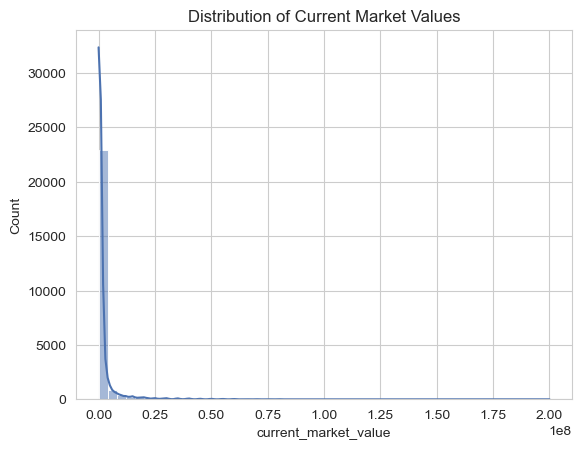

In [43]:
sns.histplot(combined_data_agg['current_market_value'], bins=50, kde=True)
plt.title("Distribution of Current Market Values")
plt.show()

Diese Verteilungsgrafik zeigt, dass die Menge der Spieler mit einem niedrigen Marktwert deutlich präsenter im Datensatz sind.

In [91]:
lineplot_data = combined_data_hist[combined_data_hist['player_id'].isin(["418560", "371998", "342229"])]

fig = px.line(
    lineplot_data,
    x='year',
    y='historical_to_date__market_value',
    color='name',  
    line_group='player_id',
    hover_data={
        'name': True,
        'goals_per_game': True,  
        'assists_per_game': True,  
        'year': True,   
    },
    title="05_Vergleich der Marktwertentwicklung mehrerer Spieler",
    labels={
        'name': "Name",
        'year': 'Jahr',
        'goals_per_game': 'Tore pro Spiel',
        'assists_per_game':'Assist pro Spiel',
        'historical_to_date__market_value': 'Marktwert (in €)'
    }
)

fig.update_layout(
    xaxis_title="Jahr",
    yaxis_title="Marktwert (in €)",
    legend_title="Spieler",
    hovermode="x unified"
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

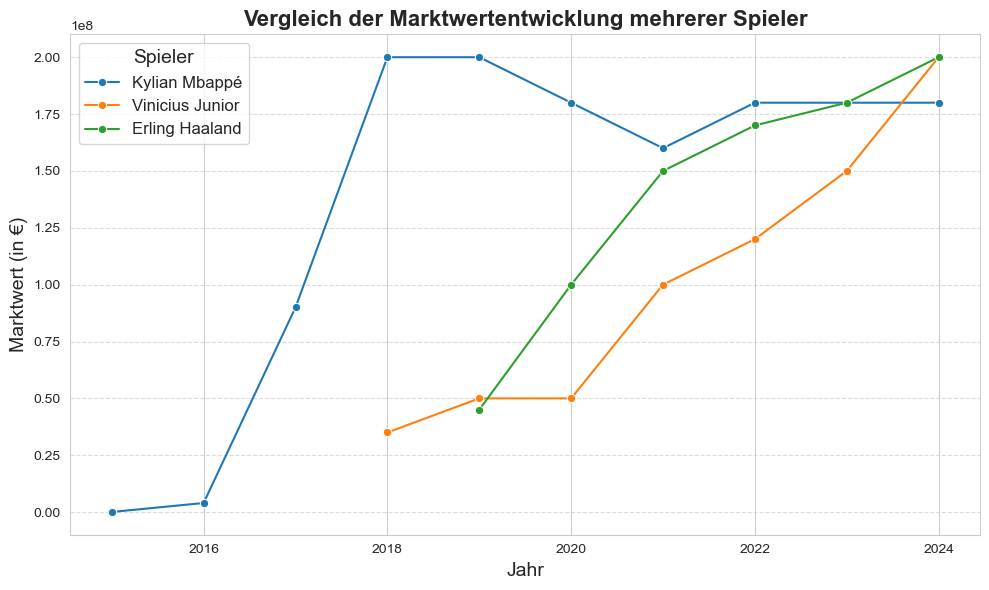

In [44]:
lineplot_data = combined_data_hist[combined_data_hist['player_id'].isin(["418560", "371998", "342229"])]

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=lineplot_data,
    x='year',
    y='historical_to_date__market_value',
    hue='name',
    marker="o",
    palette="tab10"
)

plt.title("Vergleich der Marktwertentwicklung mehrerer Spieler", fontsize=16, weight='bold')
plt.xlabel("Jahr", fontsize=14)
plt.ylabel("Marktwert (in €)", fontsize=14)
plt.legend(title="Spieler", fontsize=12, title_fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


Das Diagramm zeigt die Marktwertentwicklung dreier Spieler – Kylian Mbappé, Erling Haaland und Vinícius Júnior – über die Jahre. Alle Spieler zeigen ein konstantes Wachstum ihres Marktwerts, was ihre steigende Leistung und Attraktivität auf dem Transfermarkt widerspiegelt. Besonders Kylian Mbappé sticht hervor: Ab 2017 steigt sein Marktwert rapide an und stabilisiert sich bei ca. 200 Millionen Euro, was seine Stellung als einer der teuersten Spieler der Welt unterstreicht. Im Gegensatz dazu zeigt Erling Haaland erst ab 2019 einen signifikanten Anstieg seines Marktwerts, der mit seinem internationalen Durchbruch korreliert. Vinícius Júnior weist eine stetige, aber weniger drastische Entwicklung auf, was auf eine kontinuierliche Leistungssteigerung hindeutet. Insgesamt spiegelt das Diagramm unterschiedliche Karriereverläufe wider, wobei bei Mbappé eine Stabilisierung und bei Haaland ein starkes Wachstum erkennbar ist.

In [93]:
fig = px.scatter(
    lineplot_data,
    x='year',
    y='historical_to_date__market_value',
    color='name',
    size='goals_per_game',  
    hover_data={
        'name': True,
        'goals_per_game': True,
        'assists_per_game': True,
        'height_in_cm': True,
        'year': True,
        'age': True,
    },
    title="06_Vergleich der Marktwertentwicklung mit Toren",
    labels={
        'name': "Name",
        'year': 'Jahr',
        'historical_to_date__market_value': 'Marktwert (in €)',
        'goals_per_game': 'Tore pro Spiel',
        'assists_per_game':'Assist pro Spiel',
        'age': "Alter",
        'height_in_cm': "Größe in cm"
    }
)

fig.update_traces(mode='lines+markers')  
fig.update_layout(
    legend_title="Spieler",
    hovermode="x unified",
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")


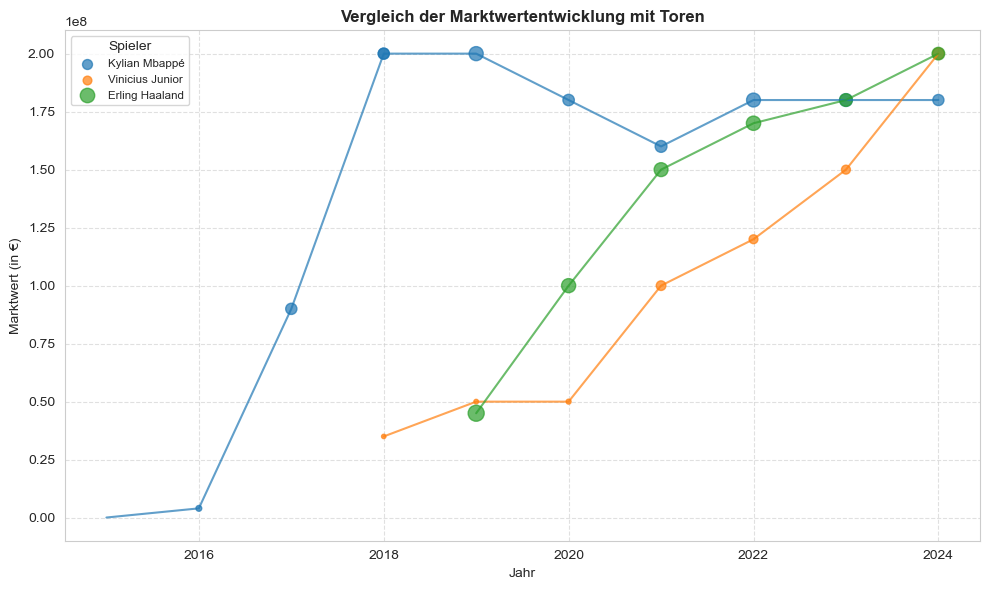

In [45]:
plt.figure(figsize=(10, 6))

lineplot_data_players = lineplot_data['name'].unique()
colors = sns.color_palette("tab10", len(lineplot_data_players))

for i, player in enumerate(lineplot_data_players):
    player_data = lineplot_data[lineplot_data['name'] == player]
    plt.scatter(
        player_data['year'], 
        player_data['historical_to_date__market_value'], 
        s=player_data['goals_per_game'] * 100,  
        color=colors[i], 
        label=player,
        alpha=0.7
    )
    plt.plot(
        player_data['year'], 
        player_data['historical_to_date__market_value'], 
        color=colors[i], 
        alpha=0.7
    )

plt.title("Vergleich der Marktwertentwicklung mit Toren", weight='bold')
plt.xlabel("Jahr")
plt.ylabel("Marktwert (in €)")
plt.legend(title="Spieler", loc="upper left", fontsize="small")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


Diese Diagramm erweitert die Analyse, indem es den Marktwert mit der Anzahl der Tore pro Spiel (dargestellt durch die Kreisgrößen) verknüpft. Hier zeigt sich ein klarer Zusammenhang: Spieler mit höheren Torzahlen, wie Erling Haaland ab 2020, tendieren zu einem stark ansteigenden Marktwert. Kylian Mbappé hingegen bleibt unabhängig von seiner Torleistung auf konstant hohem Marktwert, was zeigt, dass sein Status als Starspieler und sein Werbewert eine zentrale Rolle spielen. Vinícius Júnior hat kleinere Kreise (weniger Tore pro Spiel), bleibt aber dennoch stabil im Marktwert. Besonders auffällig ist die Entwicklung Haalands: Seine Leistungssteigerung in Form vieler Tore führt zu einer entsprechenden Steigerung seines Marktwerts. Dieses Diagramm unterstreicht, wie sportliche Leistungen, insbesondere Tore, bei aufstrebenden Spielern den Marktwert beeinflussen, während bei etablierten Stars wie Mbappé andere Faktoren dominieren.

##### Analyse nach Postition

Im folgenden werden nach Postion der Spieler analysiert.

In [95]:
avg_value = combined_data_agg.groupby("position")["current_market_value"].mean().reset_index()
avg_value = avg_value.sort_values("current_market_value", ascending=False)
fig = px.bar(avg_value, x="position", y="current_market_value",
             title="07_Durchschnittlicher Marktwert pro Position",
             labels={'position': 'Position', 'current_market_value': 'Marktwert (€)'},
             color="current_market_value",  
             color_continuous_scale="magma" )
fig.update_coloraxes(colorbar_title="Marktwert (€)")
#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")


/var/folders/df/9tj0fbwx73g3tg845tnm3j480000gn/T/ipykernel_78191/3417089879.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




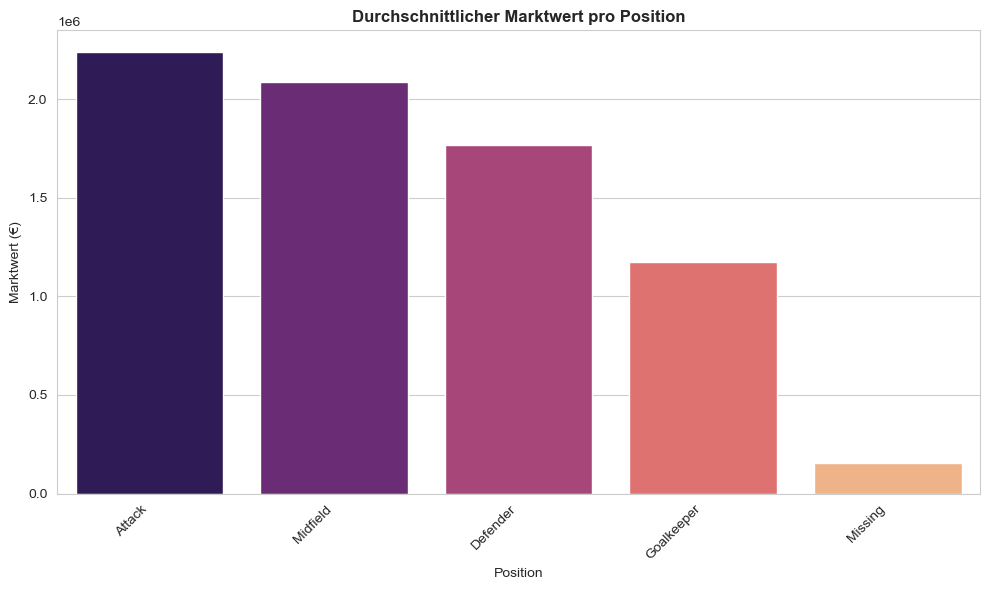

In [46]:
avg_value = combined_data_agg.groupby("position")["current_market_value"].mean().reset_index()
avg_value = avg_value.sort_values("current_market_value", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_value,
    x="position",
    y="current_market_value",
    palette="magma"
)

plt.title("Durchschnittlicher Marktwert pro Position", weight='bold')
plt.xlabel("Position")
plt.ylabel("Marktwert (€)")
plt.xticks(rotation=45, ha="right")
plt.colorbar = plt.colorbar
plt.tight_layout()
plt.show()

Das Diagramm zeigt den durchschnittlichen Wert des Martkwerts der Positionen. Es werden in vier Postionen unterteilt, wobei einige Spieler keinen EIntrag haben. Stürmer haben im Durchschnitt einen höheren Martkwert, die Torhüter dagegen die niedrigsten.

In [97]:
fig = px.scatter(
    combined_data_agg, 
    x='age', 
    y='current_market_value', 
    color="position",
    title="08_Scatterplot: Marktwert vs. Alter",
    labels={'age': 'Alter (in Jahren)', 'current_market_value': 'Marktwert (€)'}, 
    hover_data=["name", "age"] 
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

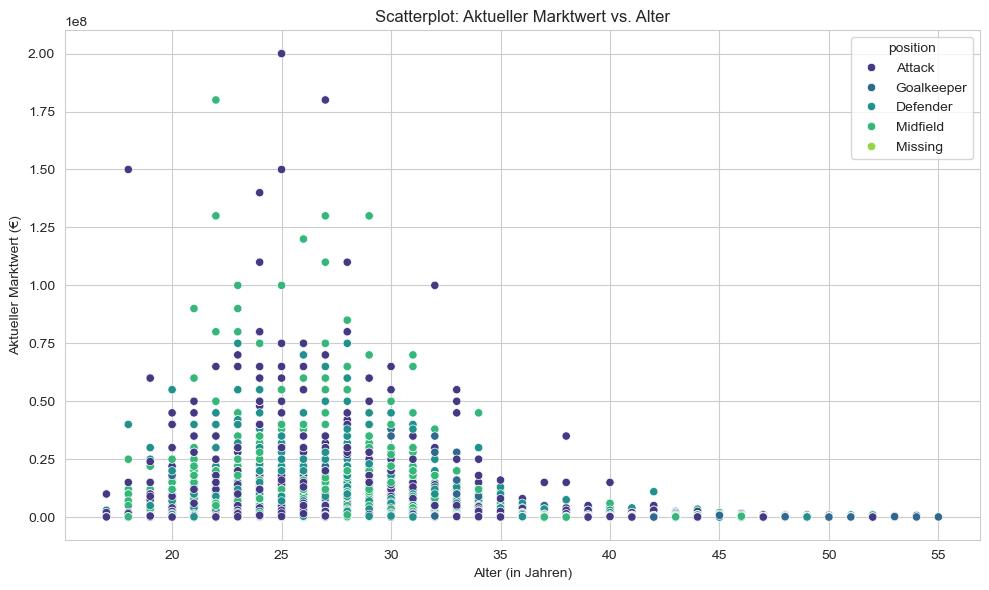

In [47]:
plt.figure(figsize=(10, 6))

# Erstelle den Scatterplot
sns.scatterplot(data=combined_data_agg, 
                x='age', 
                y='current_market_value', 
                hue="position",  
                palette='viridis') 

# Setze Achsentitel und Diagrammtitel
plt.xlabel('Alter (in Jahren)')
plt.ylabel('Aktueller Marktwert (€)')
plt.title('Scatterplot: Aktueller Marktwert vs. Alter')
plt.tight_layout()
plt.show()

Ältere Spieler haben tendenziell einen niedrigeren Marktwert. Es gibt jedoch auch Ausnahmen, wobei einige ältere Spieler einen hohen Marktwert aufweisen, während einige jüngere Spieler einen niedrigen Marktwert haben. Die Verteilung der Punkte zeigt, dass die Mehrheit der Spieler zwischen 20 und 35 Jahren liegt, und dass der Marktwert mit zunehmendem Alter abnimmt, was eine typische Beobachtung im Profifußball ist. Die Farbcodierung nach Position erlaubt es, die Verteilung der Marktwerte innerhalb verschiedener Positionen zu analysieren.

In [99]:
fig = px.scatter(combined_data_agg, x="height_in_cm", y="current_market_value", color="position",
                 hover_data=["name"], 
                 labels={'height_in_cm': 'Größe (in cm)', 'current_market_value': 'Marktwert (€)', 'name': "Name", "position": "Position"},
                 title="09_Alter vs. Marktwert nach Position")

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")


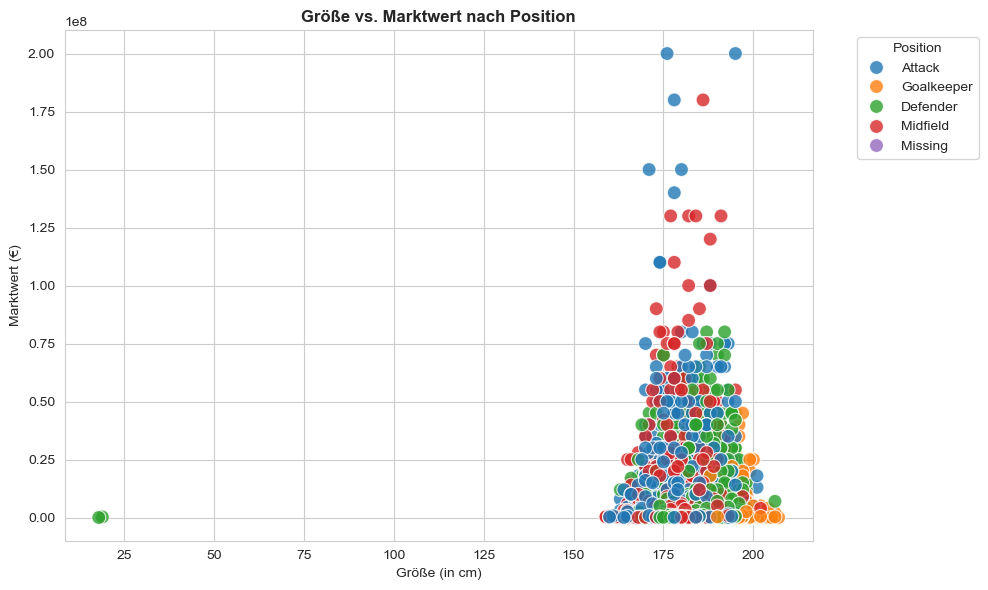

In [48]:
plt.figure(figsize=(10, 6))

scatter_plot = sns.scatterplot(
    data=combined_data_agg,
    x="height_in_cm",
    y="current_market_value",
    hue="position",
    palette="tab10",
    s=100,
    alpha=0.8
)

plt.title("Größe vs. Marktwert nach Position", weight='bold')
plt.xlabel("Größe (in cm)")
plt.ylabel("Marktwert (€)")
plt.legend(title="Position", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Die meisten Spieler konzentrieren sich um eine Körpergröße von 170-190 cm und einen Marktwert unter 100 Millionen Euro. Es scheint keine starke Korrelation zwischen Größe und Marktwert zu geben.

In [101]:
fig = px.scatter(combined_data_agg, x="total_goals", y="current_market_value", color="position",
                 hover_data=["name"], 
                 labels={'total_goals': 'Gesamt Tore', 'current_market_value': 'Marktwert (€)', 'name': "Name", "position": "Position"},
                 title="10_Gesamt Tore vs. Marktwert nach Position")
#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

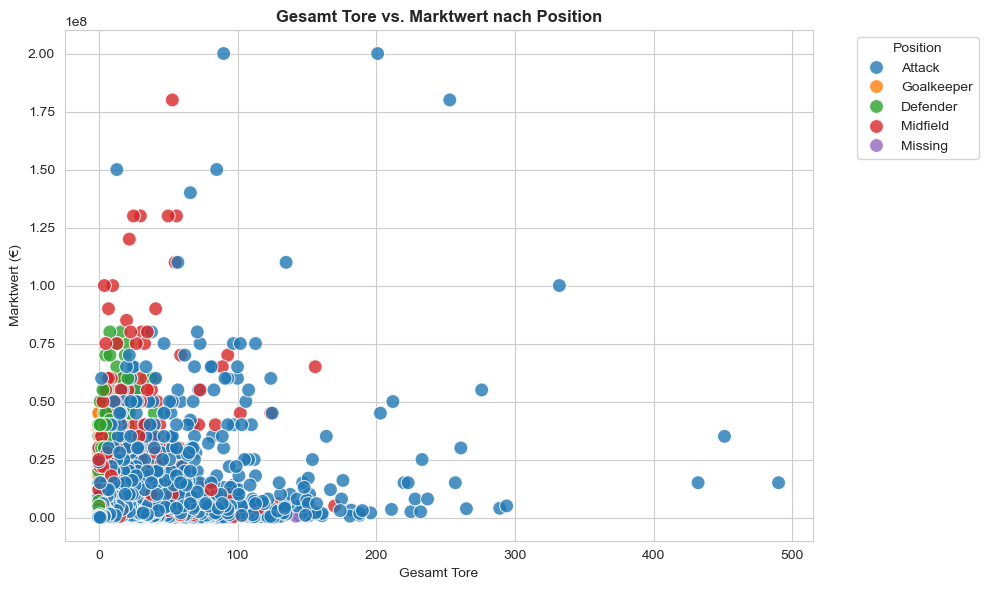

In [49]:
plt.figure(figsize=(10, 6))

scatter_plot = sns.scatterplot(
    data=combined_data_agg,
    x="total_goals",
    y="current_market_value",
    hue="position",
    palette="tab10",
    s=100,
    alpha=0.8
)

plt.title("Gesamt Tore vs. Marktwert nach Position", weight='bold')
plt.xlabel("Gesamt Tore")
plt.ylabel("Marktwert (€)")
plt.legend(title="Position", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Das Streudiagramm zeigt den Zusammenhang zwischen der Gesamtzahl der erzielten Tore und dem Marktwert von Fußballspielern, eingefärbt nach Spielerposition. Es zeigt eine Tendenz, dass Spieler mit mehr Toren einen höheren Marktwert haben, besonders im Angriff. Die Datenpunkte sind jedoch weit verstreut, was auf andere Faktoren hinweist.

In [103]:
fig = px.scatter(combined_data_agg, x="total_goals", y="current_market_value", 
                 size="total_assists", color="position", hover_name="name",
                 labels={'total_goals': 'Gesamt Tore',"total_assists":"Gesamt Assists", 'current_market_value': 'Marktwert (€)', 'name': "Name", "position": "Position"},
                 title="11_Marktwert vs. Tore (Größe: Assists)")
#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")


In [50]:

fig_data = combined_data_hist.groupby(['year', 'position'])['historical_to_date__market_value'].mean().reset_index()


fig = px.line(fig_data, x='year', y='historical_to_date__market_value', color='position',
              title='12_Entwicklung des durchschnittlichen Marktwerts nach Position',
              labels={'year': 'Datum', 
                      'historical_to_date__market_value': 'Durchschnittlicher Marktwert',
                      'position': 'Position'})


fig.update_layout(legend_title_text='Position')
fig.update_xaxes(title_text='Datum')
fig.update_yaxes(title_text='Durchschnittlicher Marktwert (€)')
fig.update_layout(
    hovermode="x unified"
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

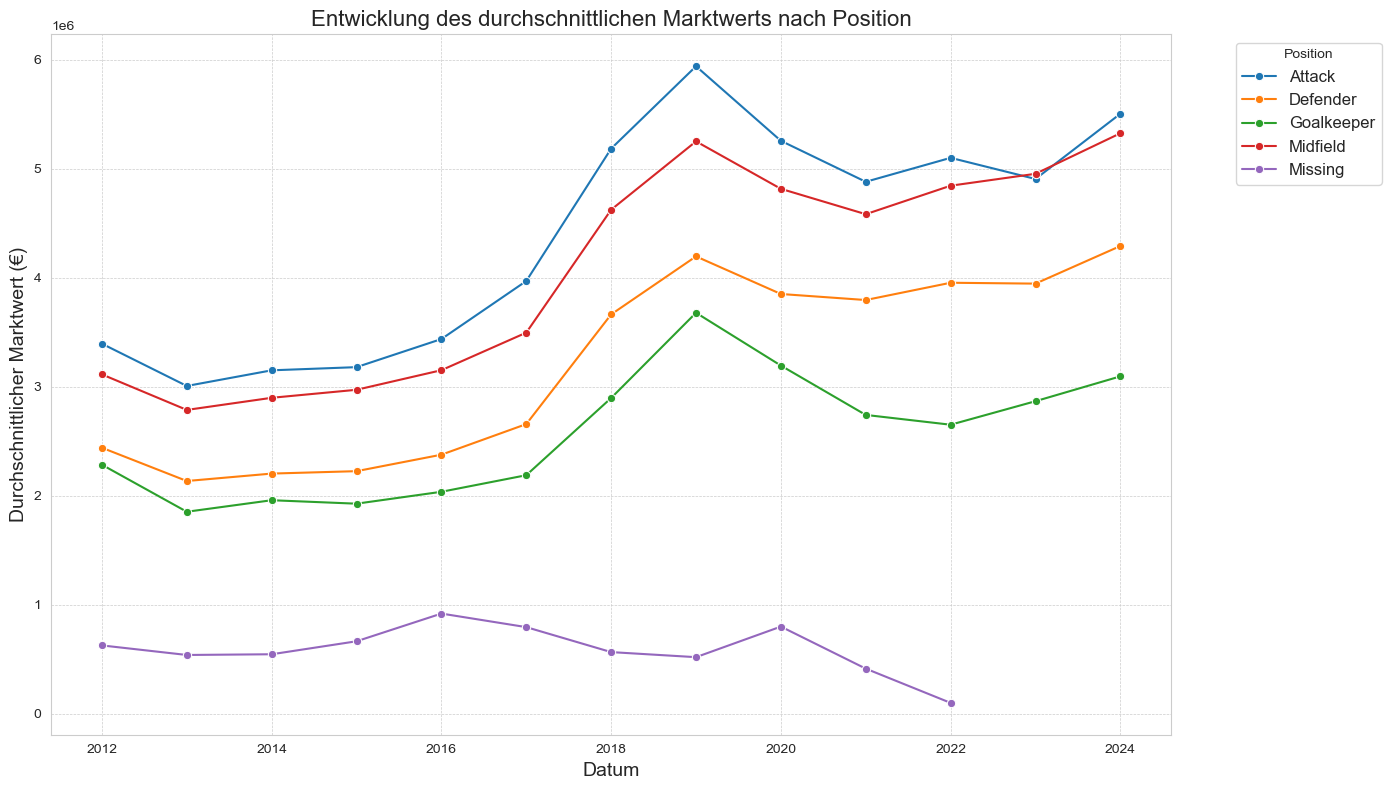

In [51]:
fig_data = combined_data_hist.groupby(['year', 'position'])['historical_to_date__market_value'].mean().reset_index()

plt.figure(figsize=(14, 8))

sns.lineplot(
    data=fig_data,
    x='year',
    y='historical_to_date__market_value',
    hue='position',
    palette='tab10',
    marker="o"
)

plt.title('Entwicklung des durchschnittlichen Marktwerts nach Position', fontsize=16)
plt.xlabel('Datum', fontsize=14)
plt.ylabel('Durchschnittlicher Marktwert (€)', fontsize=14)
plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Die Grafik zeigt die Entwicklung des durchschnittlichen Marktwerts von Fußballspielern über die Jahre, getrennt nach Positionen (Angriff, Abwehr, Torwart, Mittelfeld und fehlende Daten). Der Marktwert stieg für die meisten Positionen im Laufe der Zeit an, wobei Angreifer im Allgemeinen den höchsten Marktwert aufweisen. Es gibt Schwankungen von Jahr zu Jahr, aber ein genereller Aufwärtstrend ist erkennbar.

In [106]:
goalkeepers = combined_data_hist[combined_data_hist['position'] == 'Goalkeeper']

fig = px.scatter(goalkeepers, 
                 x='height_in_cm', 
                 y='current_market_value',
                 hover_data=['name', 'age'],
                 labels={'current_market_value': 'Marktwert (€)', "age":"Alter", 'name': "Name", "position": "Position", 'height_in_cm': 'Größe (in cm)'},
                 title='13_Torwart: Größe vs. Marktwert')

fig.update_layout(
    xaxis_title='Größe (cm)',
    yaxis_title='Marktwert (€)'
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

/var/folders/df/9tj0fbwx73g3tg845tnm3j480000gn/T/ipykernel_78191/2928828744.py:4: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



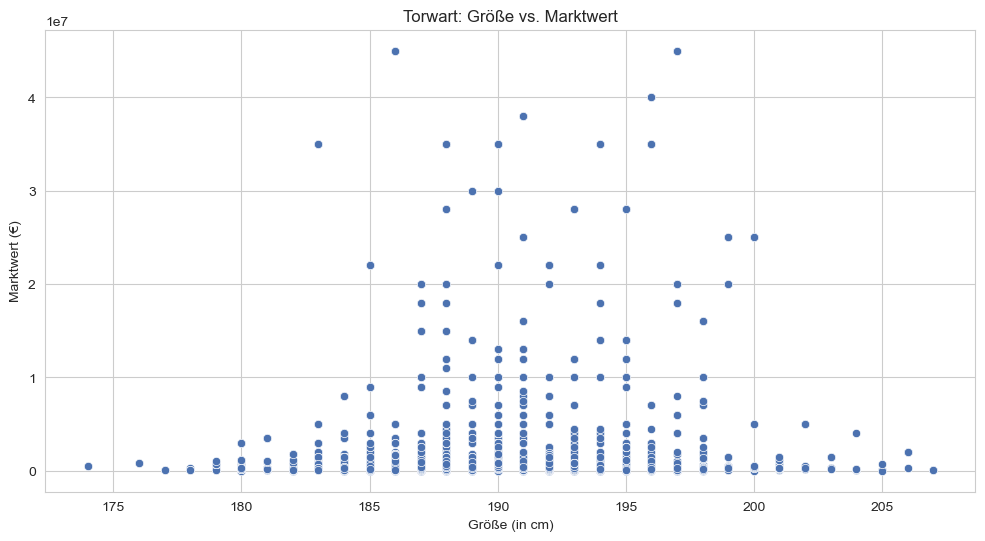

In [52]:
goalkeepers = combined_data_hist[combined_data_hist['position'] == 'Goalkeeper']

plt.figure(figsize=(12, 6))
sns.scatterplot(data=goalkeepers, 
                x='height_in_cm', 
                y='current_market_value', 
                #hue='age', 
                #style='age', 
                palette='viridis', 
                legend=None)

plt.xlabel('Größe (in cm)')
plt.ylabel('Marktwert (€)')
plt.title('Torwart: Größe vs. Marktwert')

plt.show()

Der Streudiagramm zeigt die Beziehung zwischen der Größe und dem Marktwert von Torhütern. Die meisten Torhüter liegen in einer Größenspanne von etwa 185 bis 200 cm, wobei der Marktwert in diesem Bereich variiert und keine eindeutige Korrelation zwischen Größe und Marktwert zu erkennen ist. Es gibt Ausreißer sowohl bei der Größe als auch beim Marktwert.

In [108]:
defenders = combined_data_hist[combined_data_hist['sub_position'].isin(['Centre-Back', 'Left-Back', 'Right-Back'])]

fig = px.scatter(defenders, 
                 x='height_in_cm', 
                 y='current_market_value',
                 color='sub_position',
                 hover_data=['name', 'age', 'yellow_cards_per_game'],
                 labels={'current_market_value': 'Marktwert (€)',"yellow_cards_per_game":"Gelbe Karten Pro Spiel", "sub_position":"Sub-Position", "age":"Alter", 'name': "Name", "position": "Position", 'height_in_cm': 'Größe (in cm)'},
                 title='14_Verteidiger: Größe vs. Marktwert')

fig.update_layout(
    xaxis_title='Größe (cm)',
    yaxis_title='Marktwert (€)',
    legend_title='Position'
)
#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

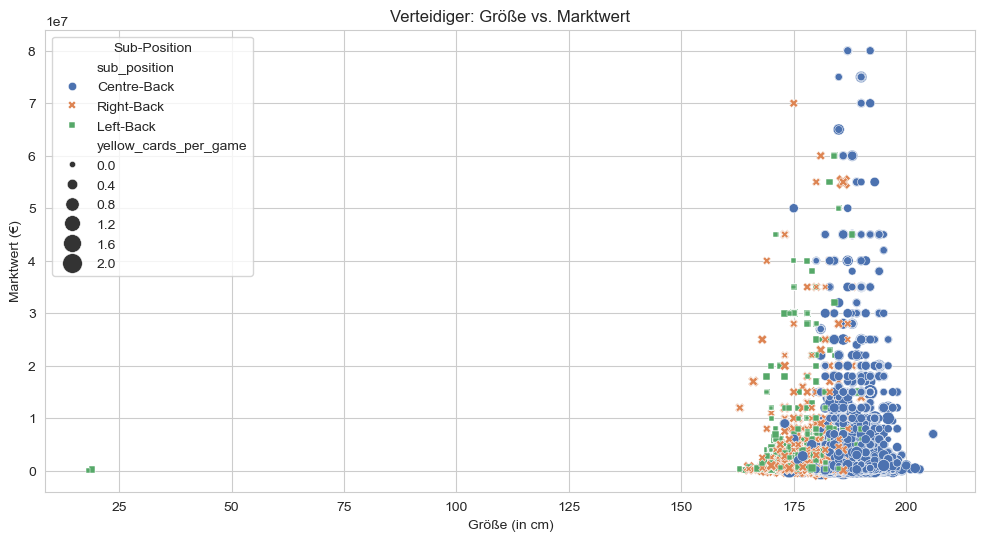

In [53]:
defenders = combined_data_hist[combined_data_hist['sub_position'].isin(['Centre-Back', 'Left-Back', 'Right-Back'])]

plt.figure(figsize=(12, 6))
sns.scatterplot(data=defenders, 
                x='height_in_cm', 
                y='current_market_value', 
                hue='sub_position', 
                palette='deep', 
                style='sub_position', 
                size='yellow_cards_per_game', 
                sizes=(20, 200))

plt.xlabel('Größe (in cm)')
plt.ylabel('Marktwert (€)')
plt.title('Verteidiger: Größe vs. Marktwert')
plt.legend(title='Sub-Position')

plt.show()

Das Streudiagramm zeigt den Marktwert von Verteidigern in Abhängigkeit von ihrer Körpergröße. Die Punkte sind nach Unterposition (Innenverteidiger, Rechtsverteidiger, Linksverteidiger) und der Anzahl der erhaltenen gelben Karten pro Spiel farblich und größenmäßig codiert. Es deutet sich eine Tendenz an, dass größere Spieler einen höheren Marktwert haben. Dazu zeigt die Grafik, dass Innneverteidiger tendenziell größer sind. Die Größe der Punkte verdeutlicht den Einfluss der Anzahl der gelben Karten auf den Marktwert.

In [110]:
midfielders = combined_data_agg[combined_data_agg['sub_position'].isin(['Defensive Midfield', 'Central Midfield', 'Attacking Midfield'])]

fig = px.scatter(midfielders, 
                 x='total_assists', 
                 y='current_market_value',
                 color='sub_position',
                 hover_data=['name', 'age', 'total_goals'],
                 labels={'current_market_value': 'Marktwert (€)',"total_goals":"Gesamte Tore", "sub_position":"Sub-Position", "age":"Alter", 'name': "Name", "total_assists": "Gesamte Assists", 'height_in_cm': 'Größe (in cm)'},
                 title='15_Mittelfeldspieler: Vorlagen pro Spiel vs. Marktwert')

fig.update_layout(
    xaxis_title='Vorlagen pro Spiel',
    yaxis_title='Marktwert (€)',
    legend_title='Position'
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

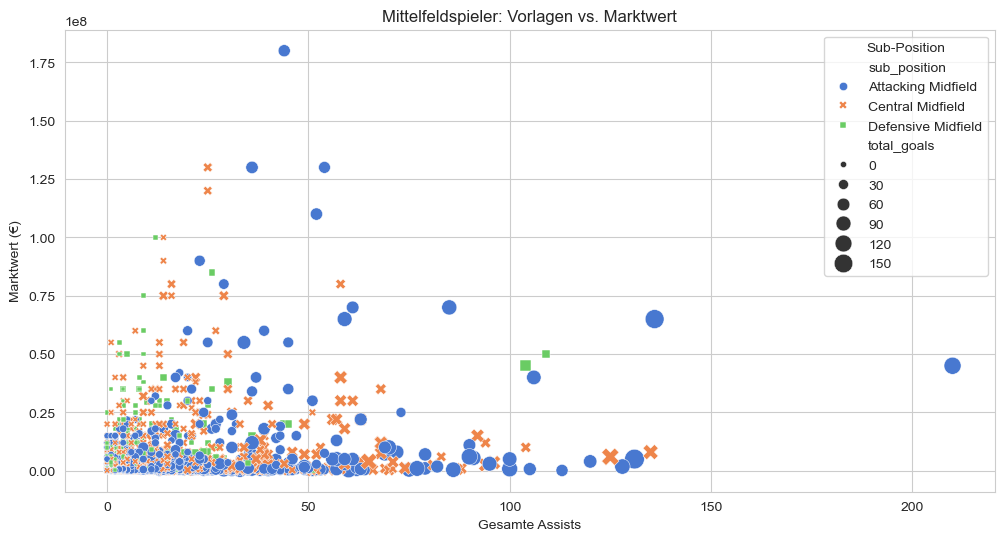

In [54]:
midfielders = combined_data_agg[combined_data_agg['sub_position'].isin(['Defensive Midfield', 'Central Midfield', 'Attacking Midfield'])]

plt.figure(figsize=(12, 6))
sns.scatterplot(data=midfielders, 
                x='total_assists', 
                y='current_market_value', 
                hue='sub_position', 
                palette='muted', 
                style='sub_position', 
                size='total_goals', 
                sizes=(20, 200))

plt.xlabel('Gesamte Assists')
plt.ylabel('Marktwert (€)')
plt.title('Mittelfeldspieler: Vorlagen vs. Marktwert')
plt.legend(title='Sub-Position')

plt.show()

Das Streudiagramm zeigt den Marktwert von Mittelfeldspielern in Relation zu ihren Vorlagen, unterteilt nach Unterpositionen (offensiv, zentral, defensiv) und der Anzahl der erzielten Tore. Größere Punkte repräsentieren mehr erzielte Tore. Es ist ersichtlich, dass ein höherer Marktwert tendenziell mit mehr Vorlagen einhergeht, aber die Beziehung ist nicht linear und wird durch die Spielerposition und die Anzahl der Tore beeinflusst.

In [112]:
forwards = combined_data_agg[combined_data_agg['sub_position'].isin(['Centre-Forward', 'Second Striker', 'Left Winger', 'Right Winger'])]

fig = px.scatter(forwards, 
                 x='total_goals', 
                 y='current_market_value',
                 color='sub_position',
                 hover_data=['name', 'age', 'total_assists'],
                 labels={'current_market_value': 'Marktwert (€)',"total_goals":"Gesamte Tore", "sub_position":"Sub-Position", "age":"Alter", 'name': "Name", "total_assists": "Gesamte Assists", 'height_in_cm': 'Größe (in cm)'},
                 title='16_Stürmer: Tore pro Spiel vs. Marktwert')

fig.update_layout(
    xaxis_title='Tore pro Spiel',
    yaxis_title='Marktwert (€)',
    legend_title='Position'
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

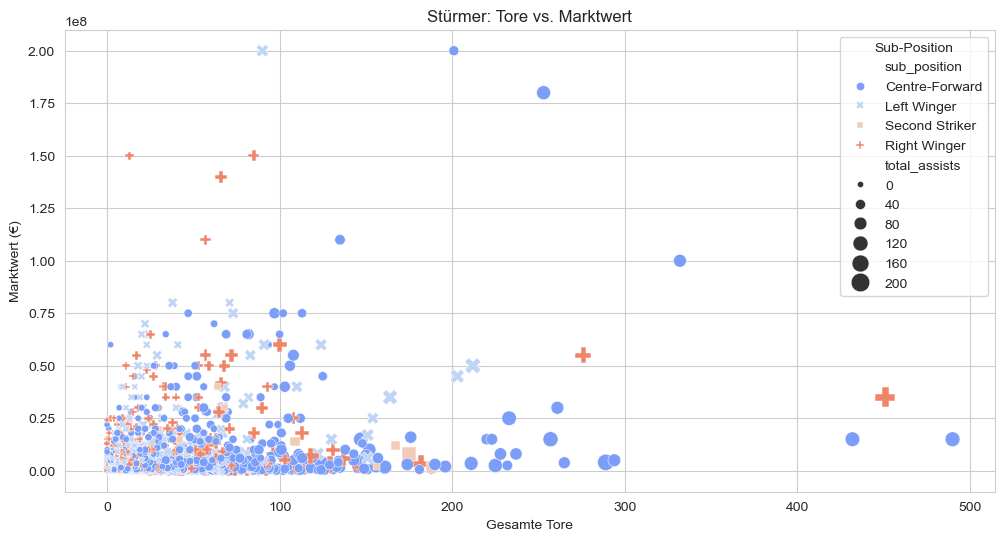

In [55]:
forwards = combined_data_agg[combined_data_agg['sub_position'].isin(['Centre-Forward', 'Second Striker', 'Left Winger', 'Right Winger'])]

plt.figure(figsize=(12, 6))
sns.scatterplot(data=forwards, 
                x='total_goals', 
                y='current_market_value', 
                hue='sub_position', 
                palette='coolwarm', 
                style='sub_position', 
                size='total_assists', 
                sizes=(20, 200))

plt.xlabel('Gesamte Tore')
plt.ylabel('Marktwert (€)')
plt.title('Stürmer: Tore vs. Marktwert')
plt.legend(title='Sub-Position')

plt.show()

Das Streudiagramm zeigt die Beziehung zwischen der Anzahl der Tore und dem Marktwert von Stürmern, wobei die Punkte nach Unterposition (Mittelstürmer, Linksaußen, zweiter Stürmer, Rechtsaußen) und der Anzahl der Vorlagen eingefärbt und größenmäßig codiert sind. Es deutet sich ein positiver Zusammenhang zwischen der Anzahl der Tore und dem Marktwert an, wobei die Punktgröße die Anzahl der Vorlagen repräsentiert. Die Unterposition scheint ebenfalls einen Einfluss auf den Marktwert zu haben.

In [114]:
fig = px.box(combined_data_agg, x="foot", y="current_market_value", color="position",
             title="17_Marktwert nach bevorzugtem Fuß und Position",
             labels={'current_market_value': 'Marktwert (€)',"foot":"Fuß", "position":"Position"})

fig.update_layout(
    xaxis_title="Bevorzugter Fuß",
    yaxis_title="Marktwert (€)",
    legend_title="Position"
)
#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

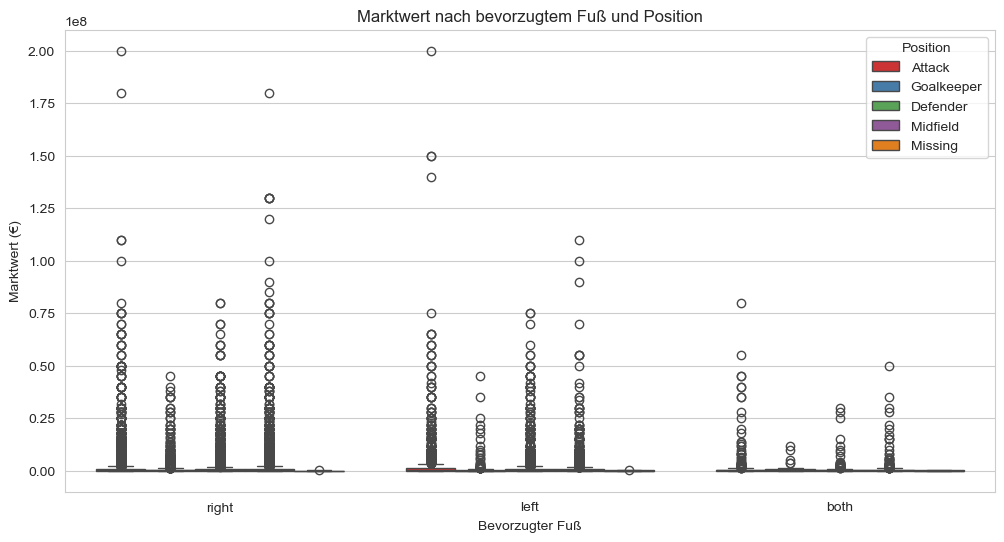

In [56]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_data_agg, 
            x='foot', 
            y='current_market_value', 
            hue='position', 
            palette='Set1') 

plt.xlabel('Bevorzugter Fuß')
plt.ylabel('Marktwert (€)')
plt.title('Marktwert nach bevorzugtem Fuß und Position')
plt.legend(title='Position')

plt.show()

Das Boxplot zeigt den Marktwert von Fußballspielern (mit Außreisern) nach ihrem bevorzugten Fuß (rechts, links, beides) und ihrer Position. Es zeigt die Verteilung der Marktwerte für jede Kombination aus bevorzugtem Fuß und Position und veranschaulicht die Streuung und Ausreißer. Der Median und die Quartile sind für jede Gruppe sichtbar. Es gibt keine offensichtliche starke Korrelation zwischen bevorzugtem Fuß und Marktwert, obwohl es Unterschiede in der Verteilung je nach Position gibt.

In [116]:
fig = px.box(combined_data_agg_no_outliers, x="foot", y="current_market_value", color="position",
             title="18_Marktwert nach bevorzugtem Fuß und Position",
             labels={'current_market_value': 'Marktwert (€)',"foot":"Fuß", "position":"Position"})

fig.update_layout(
    xaxis_title="Bevorzugter Fuß",
    yaxis_title="Marktwert (€)",
    legend_title="Position"
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

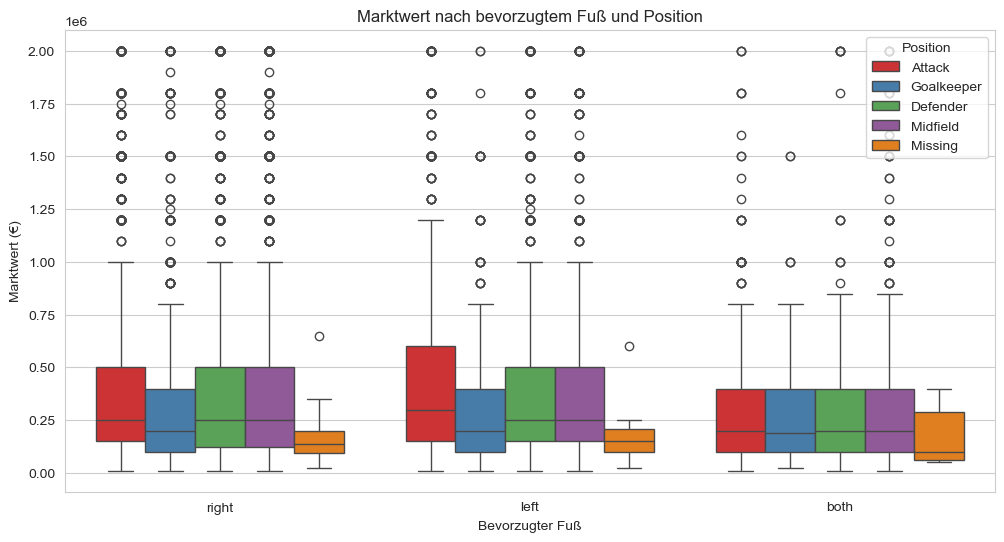

In [57]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_data_agg_no_outliers, 
            x='foot', 
            y='current_market_value', 
            hue='position', 
            palette='Set1')  

plt.xlabel('Bevorzugter Fuß')
plt.ylabel('Marktwert (€)')
plt.title('Marktwert nach bevorzugtem Fuß und Position')
plt.legend(title='Position')

plt.show()

Das Boxplot vergleicht den Marktwert von Fußballspielern (ohne Außreisern) nach ihrem bevorzugten Fuß (rechts, links, beides) und ihrer Position auf dem Feld. Es zeigt die Verteilung (Median, Quartile, Ausreißer) der Marktwerte für jede Gruppe und ermöglicht einen Vergleich der zentralen Tendenz und der Streuung für verschiedene Fuß- und Positionskombinationen.

In [118]:

top_5_leagues = ['GB1', 'ES1', 'FR1', 'IT1', 'L1']


combined_data_agg_top_league = combined_data_agg[(combined_data_agg["is_retired"] == False) & (combined_data_agg["league_id"].isin(top_5_leagues))]

fig = px.box(combined_data_agg_top_league, x="foot", y="current_market_value", color="position",
             facet_col="league_id",
             title="19_Marktwert nach bevorzugtem Fuß, Position und Liga",
             labels={'current_market_value': 'Marktwert (€)',"foot":"Fuß", "position":"Position", "league_id":"Liga"})

fig.update_layout(
    xaxis_title="Fuß",
    yaxis_title="Marktwert (€)",
    legend_title="Position"
)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

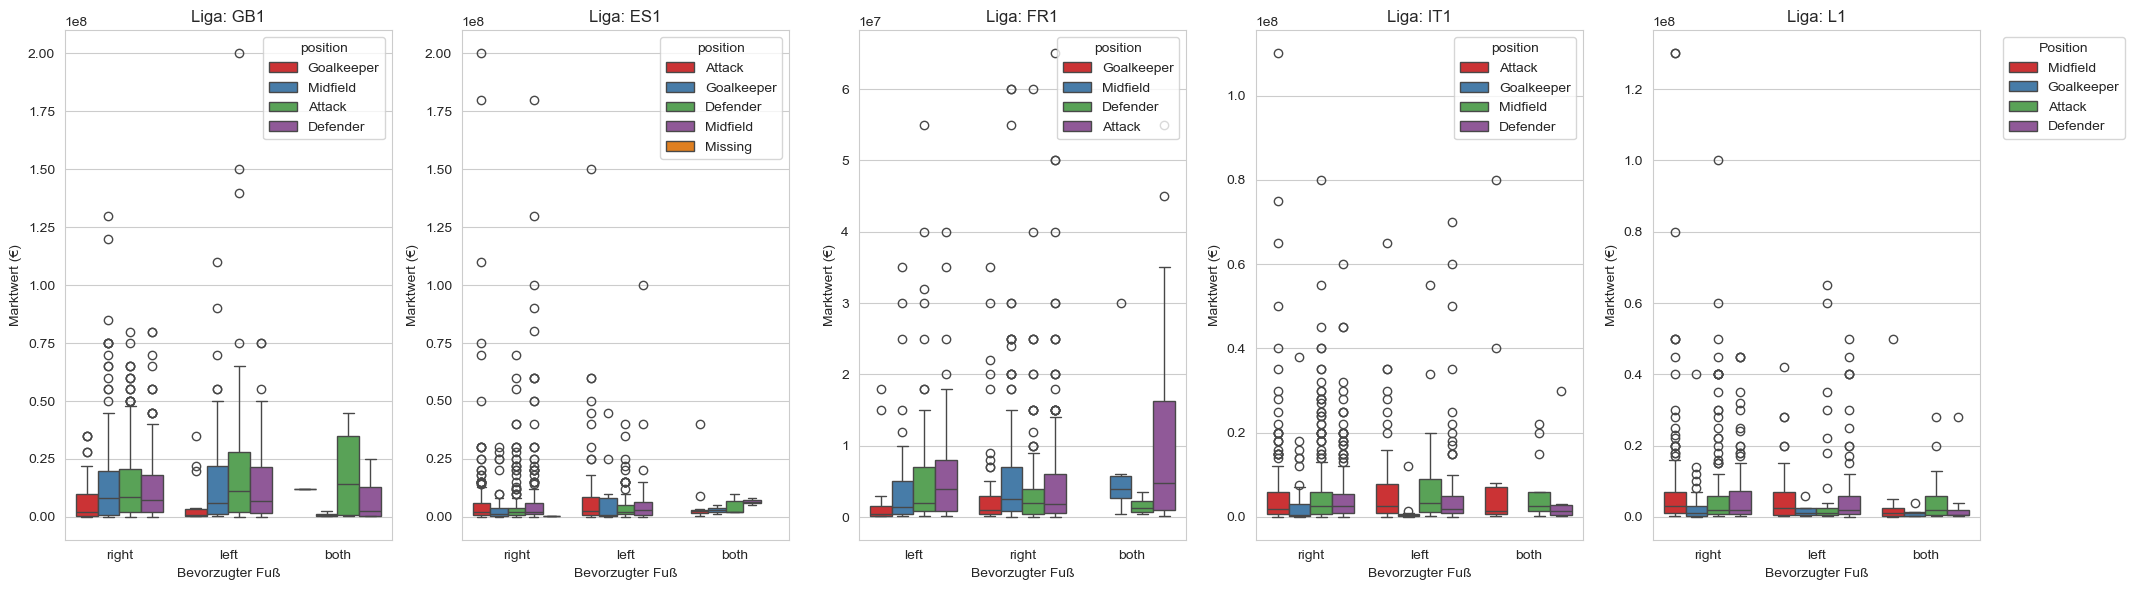

In [58]:
top_5_leagues = ['GB1', 'ES1', 'FR1', 'IT1', 'L1']
combined_data_agg_top_league = combined_data_agg[(combined_data_agg["is_retired"] == False) & 
                                                 (combined_data_agg["league_id"].isin(top_5_leagues))]

# Setze die Größe des Plots
fig, axes = plt.subplots(1, len(top_5_leagues), figsize=(20, 6))

# Erstelle für jede Liga einen Boxplot
for i, league in enumerate(top_5_leagues):
    ax = axes[i]
    sns.boxplot(data=combined_data_agg_top_league[combined_data_agg_top_league['league_id'] == league], 
                x='foot', 
                y='current_market_value', 
                hue='position', 
                palette='Set1', 
                ax=ax)
    ax.set_title(f"Liga: {league}")
    ax.set_xlabel('Bevorzugter Fuß')
    ax.set_ylabel('Marktwert (€)')

# Titel und Layout anpassen
plt.tight_layout()
plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Die Grafik vergleicht den Marktwert von Fußballspielern in fünf verschiedenen Ligen nach bevorzugtem Fuß (rechts, links, beides) und Position. Angreifer haben in allen Ligen den höchsten medianen Marktwert. Der bevorzugte Fuß zeigt keinen signifikanten Einfluss auf den Marktwert, außer in der Liga FR1, wo Linksfüßer einen höheren Medianwert aufweisen. Die Streuung der Marktwerte ist in allen Ligen und Positionen hoch. Es gibt keine aussagekräftigen Kennzahlen, da die Grafik keine numerischen Werte enthält, sondern nur die Verteilung visualisiert.

In [120]:


top_5_leagues = ['GB1', 'ES1', 'FR1', 'IT1', 'L1']


#combined_data_agg_top_league = combined_data_agg[(combined_data_agg["is_retired"] == False) & (combined_data_agg["league_id"].isin(top_5_leagues))]


top_countries = combined_data_agg_top_league.groupby("country_of_citizenship").agg({
    "current_market_value": "mean",
    "player_id": "count"
}).reset_index()

min_players = 50
top_countries_filtered = top_countries[top_countries["player_id"] >= min_players]

top_10_countries = top_countries_filtered.sort_values("current_market_value", ascending=False).head(10)

fig = px.bar(top_10_countries, 
             x="country_of_citizenship", 
             y="current_market_value",
             color="player_id",  # Farbkodierung basierend auf der Anzahl der Spieler
             text="player_id",
             labels={'current_market_value': 'Marktwert (€)',"foot":"Fuß", "country_of_citizenship":"Staatsbügerschaft", "league_id":"Liga"},
             title=f"20_Top 10 Länder nach durchschnittlichem Marktwert (nur aktive Spieler in Top 5 Ligen, mind. {min_players} Spieler)")

fig.update_layout(
    xaxis_title="Land der Staatsbürgerschaft",
    yaxis_title="Durchschnittlicher Marktwert (€)",
    xaxis_tickangle=-45,
    coloraxis_colorbar_title="Anzahl der Spieler"
)


fig.update_traces(texttemplate='%{text} Spieler', textposition='outside')

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")



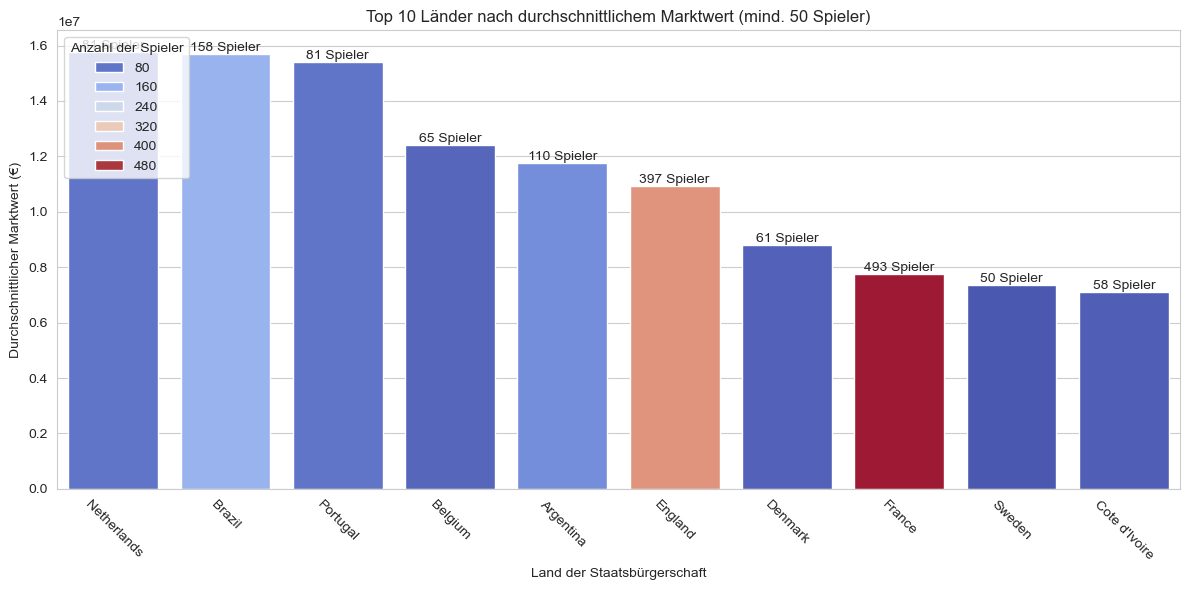

In [59]:
min_players = 50
top_countries = combined_data_agg_top_league.groupby("country_of_citizenship").agg({
    "current_market_value": "mean",
    "player_id": "count"
}).reset_index()

top_countries_filtered = top_countries[top_countries["player_id"] >= min_players]

top_10_countries = top_countries_filtered.sort_values("current_market_value", ascending=False).head(10)

# Setze die Größe des Plots
plt.figure(figsize=(12, 6))

# Erstelle das Balkendiagramm
sns.barplot(data=top_10_countries, 
            x='country_of_citizenship', 
            y='current_market_value', 
            hue='player_id',  # Farbkodierung basierend auf der Anzahl der Spieler
            palette='coolwarm')

# Füge die Anzahl der Spieler als Textbeschriftung hinzu
for i in range(len(top_10_countries)):
    plt.text(i, top_10_countries['current_market_value'].iloc[i] + 1, 
             f"{top_10_countries['player_id'].iloc[i]} Spieler", 
             ha='center', va='bottom')

# Setze Achsenbeschriftungen und Titel
plt.xlabel('Land der Staatsbürgerschaft')
plt.ylabel('Durchschnittlicher Marktwert (€)')
plt.title(f"Top 10 Länder nach durchschnittlichem Marktwert (mind. {min_players} Spieler)")

# Drehe die x-Achsenticks
plt.xticks(rotation=-45)

# Zeige den Plot an
plt.legend(title='Anzahl der Spieler', loc='upper left')
plt.tight_layout()
plt.show()

Die Grafik zeigt die Top 10 Länder mit dem höchsten durchschnittlichen Marktwert von Fußballspielern (mindestens 50 Spieler pro Land). Die Niederlande haben den höchsten durchschnittlichen Marktwert mit 158 Spielern, gefolgt von Brasilien (157 Spieler) und Portugal (81 Spieler). England liegt mit 397 Spielern auf Platz 7. Frankreich liegt mit 493 Spielern auf Platz 9.

#### Relationships

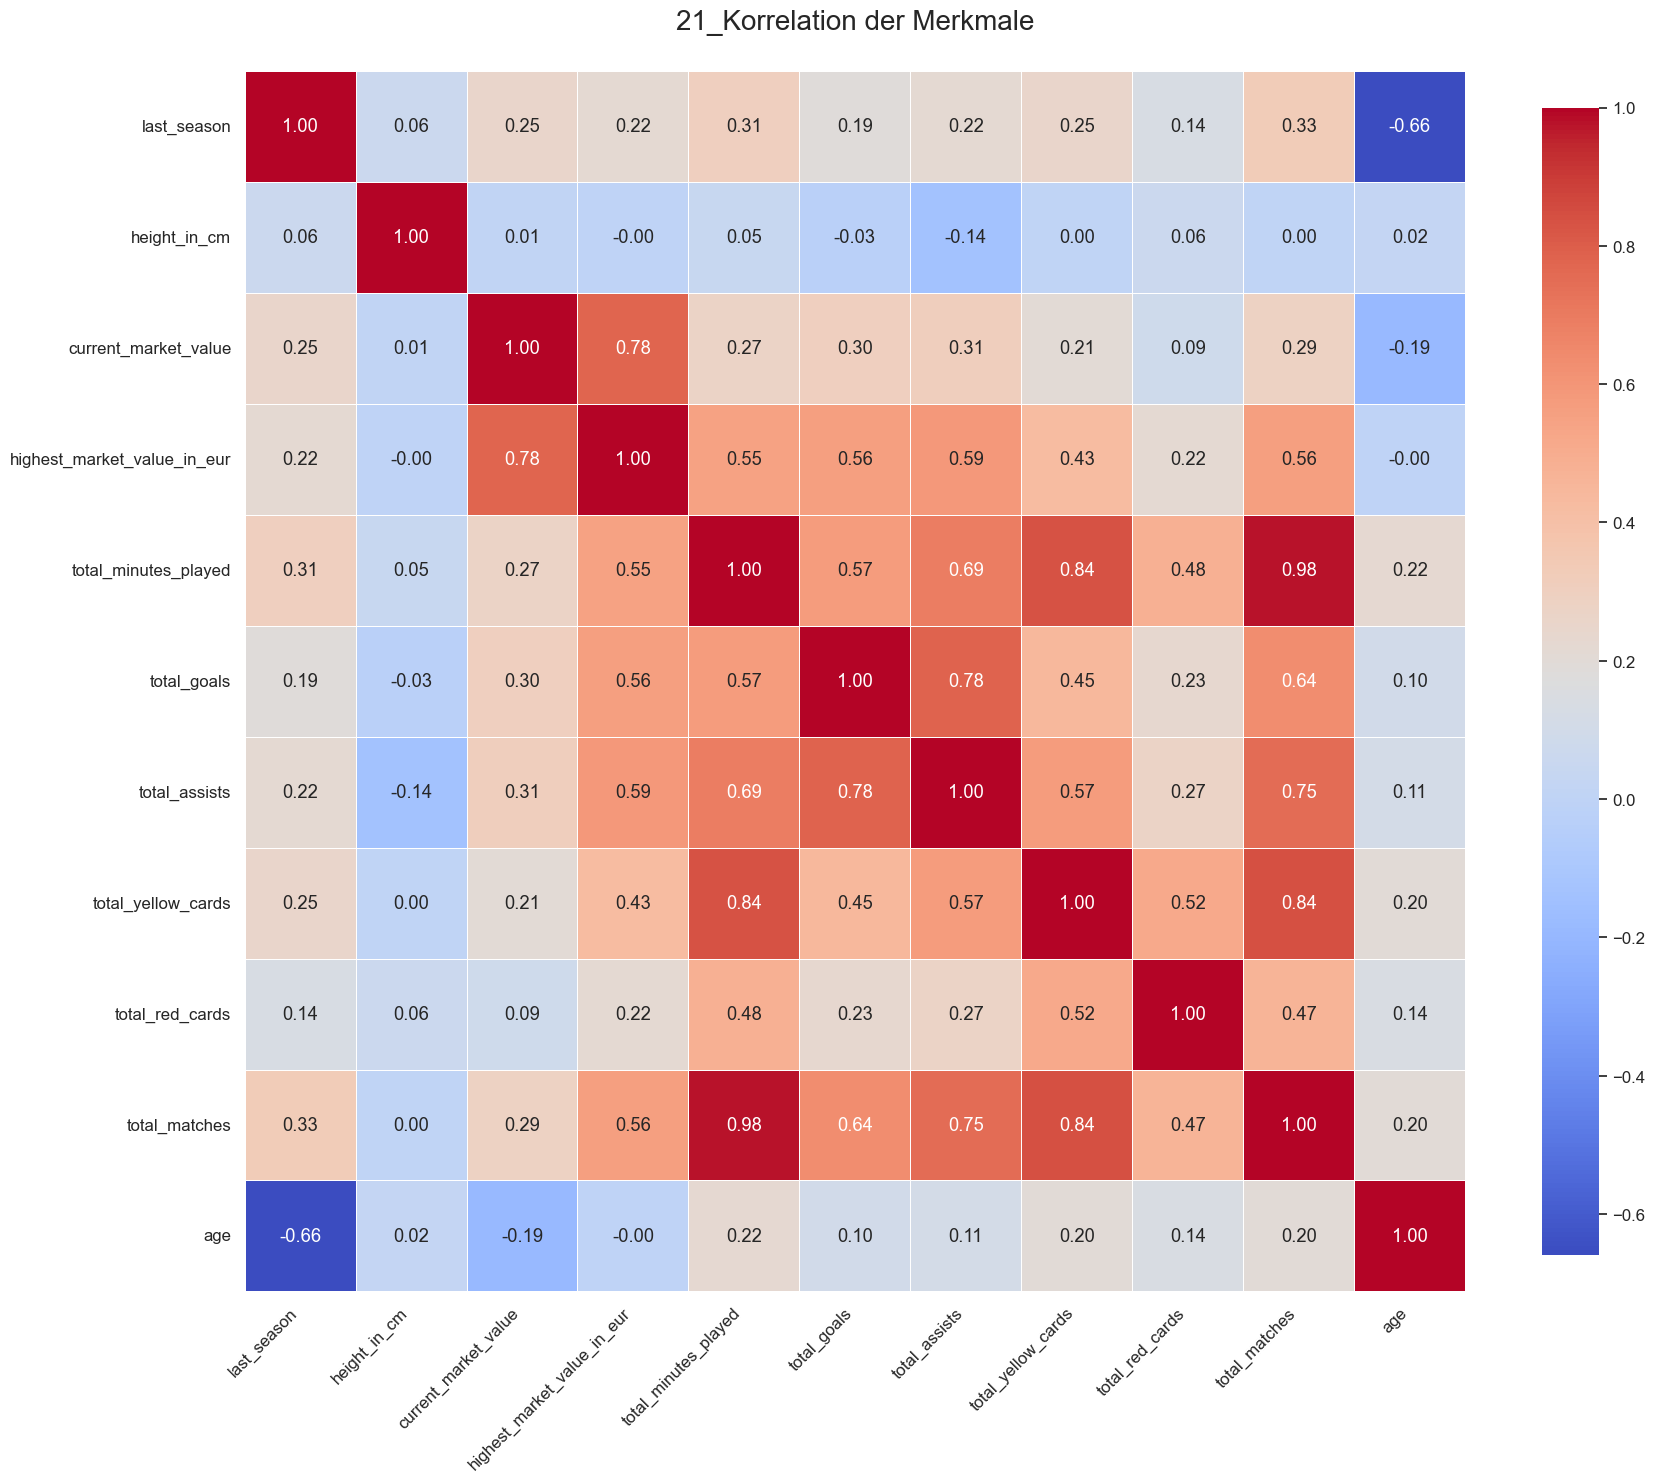

In [60]:
correlation_matrix = numeric_combined_data_agg.corr()

plt.figure(figsize=(18, 16)) 
sns.set_theme(style="white", font_scale=1.1)

sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar_kws={'shrink': 0.8},  
    linewidths=0.5, 
    square=True
)

plt.title("21_Korrelation der Merkmale", fontsize=20, pad=30)
plt.xticks(rotation=45, ha="right")  
plt.yticks(rotation=0)  
plt.tight_layout()  

safe_title = re.sub(r'[^\w\s-]', '', "01_Korrelationsmatrix").replace(' ', '_')
plt.savefig(f"../references/plotly/{safe_title}.png", dpi=300, bbox_inches="tight")

plt.show()

Die Korrelationsmatrix zeigt die linearen Zusammenhänge zwischen den verschiedenen numerischen Merkmalen des Datensatzes, die zur Vorhersage des Marktwertes von Fußballspielern verwendet werden. Werte nahe 1 oder -1 deuten auf starke positive bzw. negative Korrelationen hin, während Werte nahe 0 auf geringe oder keine Korrelation hinweisen. Beispielsweise zeigt die Variable "highest_market_value_in_eur" mit 0.72 eine starke positive Korrelation mit dem aktuellen Marktwert ("current_market_value"), was intuitiv Sinn ergibt, da der bisher höchste Marktwert eines Spielers ein guter Indikator für dessen aktuellen Marktwert ist. Variablen wie "age" und "red_cards" zeigen eher geringe oder negative Korrelationen, was darauf schließen lässt, dass diese Faktoren weniger stark mit dem Marktwert in Zusammenhang stehen.

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Features auswählen
features = numeric_combined_data_agg

# Entfernen von fehlenden Werten
features = features.dropna()

# Konstanten hinzufügen
features_with_constant = sm.add_constant(features)

# VIF berechnen
vif_data = pd.DataFrame()
vif_data['Variable'] = features_with_constant.columns
vif_data['VIF'] = [variance_inflation_factor(features_with_constant.values, i) for i in range(features_with_constant.shape[1])]

print(vif_data)


In [ ]:
data_cleaned_agg = numeric_combined_data_agg

data_cleaned_agg = data_cleaned_agg.drop(columns=[
    #'transfer_fee',              
    #'transfer_market_value',     
    'highest_market_value_in_eur',          
    'total_minutes_played',           
    'total_matches'              
])

features = data_cleaned_agg.dropna()

features_with_constant = sm.add_constant(features)

vif_data = pd.DataFrame()
vif_data['Variable'] = features_with_constant.columns
vif_data['VIF'] = [variance_inflation_factor(features_with_constant.values, i) for i in range(features_with_constant.shape[1])]

print(vif_data)

Der Variance Inflation Factor (VIF) misst die Multikollinearität zwischen unabhängigen Variablen in einem Datensatz. Ein hoher VIF-Wert weist darauf hin, dass eine Variable stark mit anderen korreliert ist, was in Modellen wie der linearen Regression zu Verzerrungen führen kann. In diesem Schritt wurden die VIF-Werte für alle Variablen berechnet, problematische Variablen mit sehr hohen VIF-Werten identifiziert und entweder entfernt oder so transformiert, dass die Multikollinearität reduziert wurde. Ziel war es, ein Dataframe mit unabhängigen Prädiktoren zu erstellen.

In [ ]:
data_cleaned_agg

##### Historisiert VIF

In [ ]:
numeric_combined_data_hist = combined_data_hist.select_dtypes(include=["number"])
correlation_matrix = numeric_combined_data_hist.corr()


plt.figure(figsize=(18, 16)) 
sns.set_theme(style="white", font_scale=1.1)


sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar_kws={'shrink': 0.8},  
    linewidths=0.5, 
    square=True
)


plt.title("Korrelation der Merkmale", fontsize=20, pad=30)
plt.xticks(rotation=45, ha="right")  
plt.yticks(rotation=0)  
plt.tight_layout()  
plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


features = numeric_combined_data_hist
features = features.dropna()

features_with_constant = sm.add_constant(features)

vif_data = pd.DataFrame()
vif_data['Variable'] = features_with_constant.columns
vif_data['VIF'] = [variance_inflation_factor(features_with_constant.values, i) for i in range(features_with_constant.shape[1])]

print(vif_data)

In [ ]:
data_cleaned_hist = numeric_combined_data_hist

data_cleaned_hist = data_cleaned_hist.drop(columns=[
    #'transfer_fee',              
    'transfer_market_value',  
    #'transfer_fee_gap',   
    'highest_market_value_in_eur',
    "historical_to_date__market_value"           
])

features = data_cleaned_hist.dropna()

features_with_constant = sm.add_constant(features)

vif_data_hist = pd.DataFrame()
vif_data_hist['Variable'] = features_with_constant.columns
vif_data_hist['VIF'] = [variance_inflation_factor(features_with_constant.values, i) for i in range(features_with_constant.shape[1])]

print(vif_data_hist)


## Methodology

Die Analyse des Marktwerts von Profifußballspielern wurde durch einen mehrstufigen, systematischen Modellierungsansatz realisiert. Die methodologische Herangehensweise basierte auf der Prämisse, dass die Komplexität der Marktwertbildung eine differenzierte Betrachtung verschiedener Datenstrukturen und Modellierungsansätze erfordert. Der Datensatz wurde in zwei fundamentale analytische Kategorien unterteilt: **aggregierte** und **historische** Daten. Diese Unterscheidung ermöglichte eine umfassende Untersuchung sowohl statischer als auch zeitabhängiger Einflussfaktoren auf die Marktwertentwicklung.
Für jede dieser Kategorien wurden drei distinkte Datenvarianten analysiert:

- Der vollständige Datensatz zur Erfassung des gesamten Marktspektrums
- Ein um Ausreißer bereinigter Datensatz zur Verbesserung der Modellstabilität
- Ein spezialisierter Datensatz der europäischen Top-5-Ligen zur Fokussierung auf Premium-Marktsegmente

Die Modellierung basierte auf 11 bzw. 15 Prediktor-Variablen, die sowohl statische Merkmale (Größe, Nationalität, Fuß, Position) als auch dynamische Leistungsindikatoren (Tore pro Spiel, Assists pro Spiel, Spielminuten) umfassen. Die Zielvariable wurde als `current_market_value` definiert. Die Auswahl dieser Features erfolgte unter Berücksichtigung ihrer sportlichen und ökonomischen Relevanz für die Marktwertbestimmung.
Für die Modellierung wurden vier verschiedene Algorithmen implementiert:

1. Lineare Regression als Baseline-Modell
    - Dient als Baseline-Modell
    - Ermöglicht die Identifikation linearer Zusammenhänge
    - Bietet hohe Interpretierbarkeit
2. Random Forest
    - Erfasst nicht-lineare Beziehungen
    - Reduziert Overfitting durch Ensemble-Methodik
    - Ermöglicht Feature-Importance-Analyse
3. Gradient Boosting
    - Optimiert sequentiell auf Residuen
    - Bietet hohe Anpassungsfähigkeit
    - Ermöglicht feine Modellabstimmung
4. Historisches Gradient Boosting
    - Spezialisiert auf zeitliche Entwicklungen
    - Berücksichtigt historische Trends
    - Optimiert für temporale Datenstrukturen

Die Modellselektion erfolgte durch systematischen Vergleich der Leistungsmetriken MSE (Mean Squared Error), R² (Bestimmtheitsmaß) und MAPE (Mean Abssolute Percentage Error) wobei besonderes Augenmerk auf die Robustheit der Vorhersagen gelegt wurde.


- MSE - zeigt quadrierte Abweichungen
- R² - zeigt erklärte Varianz
- MAPE - zeigt prozentuale Abweichung

Dabei ist zu beachten, dass der MSE aufgrund der hohen Wertespanne in der Zielvariable (Marktwerte von mehreren tausend bis zu mehreren Millionen Euro) naturgemäß sehr große Werte annimmt. Diese Skalierungsabhängigkeit des MSE muss bei der Interpretation der Ergebnisse berücksichtigt werden.

#### Variable lists

Historisierte Daten für die Modellierung apassen. Für die aggregierten ist das bereits im Zuge der Analysen geschehen

In [129]:
combined_data_hist_top_league = combined_data_hist[(combined_data_hist["is_retired"] == False) & (combined_data_hist["league_id"].isin(top_5_leagues))]

In [130]:
q1 = combined_data_hist["current_market_value"].quantile(0.25)
q3 = combined_data_hist["current_market_value"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filtern der Daten ohne Ausreißer
combined_data_hist_no_outliers = combined_data_hist[
    (combined_data_hist["current_market_value"] >= lower_bound) & 
    (combined_data_hist["current_market_value"] <= upper_bound)
]

In [131]:
# für historisiert combined_data_hist
features_hist = [
    "historical_to_date__market_value", 
    "year",
    #"last_season", 
    "height_in_cm",
    "country_of_citizenship",
     "foot", "position", 'goals_per_game',
       'assists_per_game', 'yellow_cards_per_game', 'red_cards_per_game',
       'minutes_played_per_game','age',
       'is_retired',
       "transfer_fee_gap",
       "transfer_fee"
]

target = "current_market_value"

In [132]:
# für aggregiert combined_data_agg
features_agg = [ 
     "height_in_cm", 
     "country_of_citizenship", 
     "foot", 
     "position", 
     'total_goals',
       'total_assists', 'total_yellow_cards', 'total_red_cards',
       'total_minutes_played',
       'age',
       'is_retired'
]

target = "current_market_value"

### Modellierung

In [149]:
def model_comparison(df, features, target):
    
    X = pd.get_dummies(df[features], drop_first=True)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Nan mit Median füllen für Lin Reg und GB
    X_train_filled = X_train.fillna(X.median())
    X_test_filled = X_test.fillna(X.median())

    lr_model = LinearRegression()
    rf_model = RandomForestRegressor(n_estimators=120, max_depth=20, random_state=42)
    gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    hist_gb_model = HistGradientBoostingRegressor(random_state=42)
    

    lr_model.fit(X_train_filled, y_train)
    rf_model.fit(X_train, y_train)
    gb_model.fit(X_train_filled, y_train)
    hist_gb_model.fit(X_train, y_train)

    lr_predictions = lr_model.predict(X_test_filled)
    rf_predictions = rf_model.predict(X_test)
    gb_predictions = gb_model.predict(X_test_filled) 
    hist_gb_predictions = hist_gb_model.predict(X_test)

    # Metriken 
    lr_mse = mean_squared_error(y_test, lr_predictions)
    lr_r2 = r2_score(y_test, lr_predictions)
    lr_mape = mean_absolute_percentage_error(y_test, lr_predictions)
    
    rf_mse = mean_squared_error(y_test, rf_predictions)
    rf_r2 = r2_score(y_test, rf_predictions)
    rf_mape = mean_absolute_percentage_error(y_test, rf_predictions)

    gb_mse = mean_squared_error(y_test, gb_predictions)
    gb_r2 = r2_score(y_test, gb_predictions)
    gb_mape = mean_absolute_percentage_error(y_test, gb_predictions)

    hist_gb_mse = mean_squared_error(y_test, hist_gb_predictions) 
    hist_gb_r2 = r2_score(y_test, hist_gb_predictions)
    hist_gb_mape = mean_absolute_percentage_error(y_test, hist_gb_predictions)
    
                                                    #5                                                      #10                                                                 #15                                                 #20                                
    return lr_mse, lr_r2, rf_mse, rf_r2, gb_mse, gb_r2, hist_gb_mse, hist_gb_r2, y_test, lr_predictions, rf_predictions, gb_predictions,hist_gb_predictions, lr_mape,rf_mape,gb_mape,hist_gb_mape,lr_model,rf_model,gb_model,hist_gb_model


In [150]:
results_agg = model_comparison(combined_data_agg, features_agg, target)
results_agg_no = model_comparison(combined_data_agg_no_outliers, features_agg, target)
results_agg_top_league = model_comparison(combined_data_agg_top_league, features_agg, target)

In [153]:
results_hist = model_comparison(combined_data_hist, features_hist, target)
results_hist_no = model_comparison(combined_data_hist_no_outliers, features_hist, target)
results_hist_top_league = model_comparison(combined_data_hist_top_league, features_hist, target)

## Results

### Evaluation on test set

In [ ]:
print("=== Modellvergleich Aggregiert===")
print(f"{'Modell':<50} {'MSE':<25} {'R²':<8} {'MAPE':<10}")
print("="*95)
print(f"{'Linear Regression':<50} {results_agg[0]:<23.1f} {results_agg[1]:<10.4f}{results_agg[13]:<10.4f}")
print(f"{'Linear Regression ohne Außreiser':<50} {results_agg_no[0]:<23.1f} {results_agg_no[1]:<10.4f}{results_agg_no[13]:<10.4f}")
print(f"{'Linear Regression Top Spieler':<50} {results_agg_top_league[0]:<23.1f} {results_agg_top_league[1]:<10.4f}{results_agg_top_league[13]:<10.4f}")
print()
print(f"{'Random Forest':<50} {results_agg[2]:<23.1f} {results_agg[3]:<10.4f}{results_agg[14]:<10.4f}")
print(f"{'Random Forest ohne Außreiser':<50} {results_agg_no[2]:<23.1f} {results_agg_no[3]:<10.4f}{results_agg_no[14]:<10.4f}")
print(f"{'Random Forest Top Spieler':<50} {results_agg_top_league[2]:<23.1f} {results_agg_top_league[3]:<10.4f}{results_agg_top_league[14]:<10.4f}")
print()
print(f"{'Gradient Boosting':<50} {results_agg[4]:<23.1f} {results_agg[5]:<10.4f}{results_agg[15]:<10.4f}")
print(f"{'Gradient Boosting ohne Außreiser':<50} {results_agg_no[4]:<23.1f} {results_agg_no[5]:<10.4f}{results_agg_no[15]:<10.4f}")
print(f"{'Gradient Boosting Top Spieler':<50} {results_agg_top_league[4]:<23.1f} {results_agg_top_league[5]:<10.4f}{results_agg_top_league[15]:<10.4f}")
print()
print(f"{'Hist Gradient Boosting':<50} {results_agg[6]:<23.1f} {results_agg[7]:<10.4f}{results_agg[16]:<10.4f}")
print(f"{'Hist Gradient Boosting ohne Außreiser':<50} {results_agg_no[6]:<23.1f} {results_agg_no[7]:<10.4f}{results_agg_no[16]:<10.4f}")
print(f"{'Hist Gradient Boosting Top Spieler':<50} {results_agg_top_league[6]:<23.1f} {results_agg_top_league[7]:<10.4f}{results_agg_top_league[16]:<10.4f}")

In [ ]:
joblib.dump(results_agg_top_league[20], '../models/hist_gb_model_agg_top_league.pkl')

In [ ]:
print("=== Modellvergleich Historisiert===")
print(f"{'Modell':<50} {'MSE':<25} {'R²':<8} {'MAPE':<10}")
print("="*95)
print(f"{'Linear Regression':<50} {results_hist[0]:<23.1f} {results_hist[1]:<10.4f}{results_hist[13]:<10.4f}")
print(f"{'Linear Regression ohne Außreiser':<50} {results_hist_no[0]:<23.1f} {results_hist_no[1]:<10.4f}{results_hist_no[13]:<10.4f}")
print(f"{'Linear Regression Top Spieler':<50} {results_hist_top_league[0]:<23.1f} {results_hist_top_league[1]:<10.4f}{results_hist_top_league[13]:<10.4f}")
print()
print(f"{'Random Forest':<50} {results_hist[2]:<23.1f} {results_hist[3]:<10.4f}{results_hist[14]:<10.4f}")
print(f"{'Random Forest ohne Außreiser':<50} {results_hist_no[2]:<23.1f} {results_hist_no[3]:<10.4f}{results_hist_no[14]:<10.4f}")
print(f"{'Random Forest Top Spieler':<50} {results_hist_top_league[2]:<23.1f} {results_hist_top_league[3]:<10.4f}{results_hist_top_league[14]:<10.4f}")
print()
print(f"{'Gradient Boosting':<50} {results_hist[4]:<23.1f} {results_hist[5]:<10.4f}{results_hist[15]:<10.4f}")
print(f"{'Gradient Boosting ohne Außreiser':<50} {results_hist_no[4]:<23.1f} {results_hist_no[5]:<10.4f}{results_hist_no[15]:<10.4f}")
print(f"{'Gradient Boosting Top Spieler':<50} {results_hist_top_league[4]:<23.1f} {results_hist_top_league[5]:<10.4f}{results_hist_top_league[15]:<10.4f}")
print()
print(f"{'Hist Gradient Boosting':<50} {results_hist[6]:<23.1f} {results_hist[7]:<10.4f}{results_hist[16]:<10.4f}")
print(f"{'Hist Gradient Boosting ohne Außreiser':<50} {results_hist_no[6]:<23.1f} {results_hist_no[7]:<10.4f}{results_hist_no[16]:<10.4f}")
print(f"{'Hist Gradient Boosting Top Spieler':<50} {results_hist_top_league[6]:<23.1f} {results_hist_top_league[7]:<10.4f}{results_hist_top_league[16]:<10.4f}")


In [ ]:
joblib.dump(results_hist[18], '../models/rf_model_hist.pkl')

Der hohe MSE resultiert vor allem aus der Skalierung der Zielvariable, den Marktwerten von Fußballspielern, die teilweise extrem hoch ausfallen. Da der MSE die Fehlerwerte quadriert, wirken sich auch kleinere Abweichungen bei hohen Marktwerten überproportional stark auf das Gesamtergebnis aus. Zusätzlich tragen die große Varianz in den Daten und das Vorhandensein von Outliern – also Spielern mit außergewöhnlich hohen Marktwerten – dazu bei, dass die Fehlerspanne weiter ansteigt. Diese extremen Werte sind schwer vorherzusagen und führen zu einer Verschlechterung des MSE.

Am Wert des R2 erkennt man, dass in beiden Fällen die lineare Regression am schlechtesten die Werte approximiert. Jedoch zeigen diese Ergebnisse das es mithilfe eines Tree Modelling schwierig ist den Marktwert eines Spielers gennau vorherzusagen. Das Modell mit den besten Ergebnisse, war der Random Forest im historisierten Zusatnd.

Der MAPE (Mean Absolute Percentage Error) gibt die durchschnittliche prozentuale Abweichung an und ermöglicht damit eine skalierungsunabhängige Bewertung. Random Forest ohne Ausreißer erreicht den besten MAPE von 0,94%


In [ ]:
model_names = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Hist Gradient Boosting']
mse_values = [results_agg[0], results_agg[2], results_agg[4], results_agg[6]]  # MSE-Werte
r2_values = [results_agg[1], results_agg[3], results_agg[5], results_agg[7]]   # R²-Werte

plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(model_names))

#plt.bar(index, mse_values, bar_width, label='MSE', color='blue')
plt.bar(index + bar_width, r2_values, bar_width, label='R²', color='blue')

plt.xlabel('Modelle')
plt.ylabel('Werte')
plt.title('Modellvergleich: MSE und R²')
plt.xticks(index + bar_width / 2, model_names)
plt.legend()
plt.tight_layout()

safe_title = re.sub(r'[^\w\s-]', '', '02_Modellvergleich: MSE und R²').replace(' ', '_')

plt.savefig(f"../references/matplotlib/{safe_title}.png", dpi=300, bbox_inches="tight")

plt.show()

Diese Grafik zeigt, dass im Durchschnitt der Hist Gradient Boosing über alle Modelle hinweg die besten Ergebnissse erzielt hat. 

In [ ]:
residuals = results_agg_no[8] - results_agg_no[9] #y_test - lr_predictions

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Verteilung der Residuen – Aggregiert Linear Regression Ohne Außreiser")
plt.xlabel("Residuum")
plt.ylabel("Häufigkeit")
plt.grid(True)
safe_title = re.sub(r'[^\w\s-]', '', '03_Verteilung der Residuen – Aggregiert Linear Regression Ohne Außreiser').replace(' ', '_')

plt.savefig(f"../references/matplotlib/{safe_title}.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
residuals = results_hist_top_league[8] - results_hist_top_league[9]

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Verteilung der Residuen – Historisiert Linear Regression Top Ligen")
plt.xlabel("Residuum")
plt.ylabel("Häufigkeit")
plt.grid(True)
safe_title = re.sub(r'[^\w\s-]', '', '04_Verteilung der Residuen – Historisiert Linear Regression Top Ligen').replace(' ', '_')

plt.savefig(f"../references/matplotlib/{safe_title}.png", dpi=300, bbox_inches="tight")
plt.show()

Die Verteilung der Residuen zeigt, wie genau ein Modell die tatsächlichen Werte vorhersagen kann. Bei der Linearen Regression ist die Fehlerverteilung zwar symmetrisch um den Wert Null, jedoch deutlich breiter, welches im Vergleich den aggregierten Daten größere Fehlerquote zuzusprechen ist, als den historisierten. Dies bedeutet, dass die Lineare Regression größere Fehler (Residuen) produziert. Insbesondere zeigt der rechte Rand der Verteilung, dass das Modell einige Vorhersagen erheblich überschätzt hat. Die Häufigkeit von Residuen nahe Null ist zwar hoch, dennoch führen die großen Fehler dazu, dass die Leistung des Modells beeinträchtigt wird. Diese breitere Streuung deutet darauf hin, dass die Lineare Regression die nichtlinearen und komplexen Zusammenhänge in den Daten nicht ausreichend abbilden kann.

In [ ]:
residuals = results_agg_top_league[8] - results_agg_top_league[10]

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Verteilung der Residuen – Aggregiert Random Forest Regression Top Ligen")
plt.xlabel("Residuum")
plt.ylabel("Häufigkeit")
plt.grid(True)
safe_title = re.sub(r'[^\w\s-]', '', '05_Verteilung der Residuen – Aggregiert Random Forest Regression Top Ligen').replace(' ', '_')

plt.savefig(f"../references/matplotlib/{safe_title}.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
residuals = results_hist[8] - results_hist[10]

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Verteilung der Residuen – Historisiert Random Forest Regression Top Ligen")
plt.xlabel("Residuum")
plt.ylabel("Häufigkeit")
plt.grid(True)
safe_title = re.sub(r'[^\w\s-]', '', '06_Verteilung der Residuen – Historisiert Random Forest Regression Top Ligen').replace(' ', '_')

plt.savefig(f"../references/matplotlib/{safe_title}.png", dpi=300, bbox_inches="tight")
plt.show()

Im Vergleich dazu zeigt die Random Forest Regression eine wesentlich engere Fehlerverteilung, bei der die meisten Residuen deutlich näher an Null liegen. Dies verdeutlicht, dass die Vorhersagen des Random Forest Modells genauer sind und der Marktwert der Spieler besser approximiert wurde. Auch hier hat das historisierte Modell eine geringere Fehlerquote.

In [ ]:
residuals = results_agg[8] - results_agg[11]

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Verteilung der Residuen – Aggregiert GBT")
plt.xlabel("Residuum")
plt.ylabel("Häufigkeit")
plt.grid(True)
safe_title = re.sub(r'[^\w\s-]', '', '07_Verteilung der Residuen – Aggregiert GBT').replace(' ', '_')

plt.savefig(f"../references/matplotlib/{safe_title}.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
residuals = results_hist[8] - results_hist[11]

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Verteilung der Residuen – Historisiert GBT")
plt.xlabel("Residuum")
plt.ylabel("Häufigkeit")
plt.grid(True)
safe_title = re.sub(r'[^\w\s-]', '', '07_Verteilung der Residuen – Historisiert GBT').replace(' ', '_')

plt.savefig(f"../references/matplotlib/{safe_title}.png", dpi=300, bbox_inches="tight")
plt.show()

Auch der Gradient Boosting Tree weist auf eine enge Fehlerverteilung, bei der die meisten Residuen deutlich näher an Null liegen. Die Vorhersagen des Random Forest Modells und Gradient Boosting Tree wurden ähnlich gut approximiert.

**Ergebnisse**

Die empirischen Ergebnisse offenbaren signifikante Unterschiede in der Vorhersagequalität der implementierten Modelle, wobei sich deutliche Muster in Abhängigkeit von der Datenstruktur und dem gewählten Modellierungsansatz zeigen.

Aggregierte Daten

- **Historisches Gradient Boosting** erreichte die höchste Vorhersagegenauigkeit für Top-Spieler (R² = 0,6776).
- **Gradient Boosting** (R² = 0,6727) und **Random Forest** (R² = 0,6674) zeigten vergleichbar starke Performance.
- Die **Ausreißerbereinigung** führte zu einer substantiellen Reduktion des MSE, allerdings auf Kosten des R²-Wertes.
- Die **lineare Regression** zeigte durchweg die schwächste Performance (R² = 0,1769 bis 0,2472).

Historisierte Daten

- **Random Forest** dominierte mit der besten Gesamtperformance (R² = 0,7339, MAPE: 0,94%).
- Die **Ausreißerbereinigung** führte zu einem optimierten MSE bei moderatem R²-Verlust.
- Alle **nicht-linearen Modelle** übertrafen die lineare Regression deutlich.
- Die **Einbeziehung historischer Daten** verbesserte die Vorhersagegenauigkeit über alle Modelle hinweg.

Bemerkenswert ist, dass die lineare Regression durchgehend die schwächste Performance zeigte, was die Nichtlinearität der Zusammenhänge zwischen den Prediktor-Variablen und dem Marktwert unterstreicht. Die Ausreißerbereinigung führte bei allen Modellen zu einer Reduzierung des MSE, ging jedoch teilweise zu Lasten des R²-Wertes.

Bei der Interpretation der hohen MSE-Werte ist die Skalierung der Zielvariable zu berücksichtigen. Da Marktwerte im Profifußball von einigen Tausend bis zu mehreren hundert Millionen Euro reichen, führen selbst prozentual moderate Abweichungen zu hohen quadrierten Fehlern. Beispielsweise würde eine Vorhersage von 45 Millionen Euro bei einem tatsächlichen Marktwert von 50 Millionen Euro trotz einer relativ präzisen Schätzung (10% Abweichung) zu einem quadrierten Fehler von 25 Millionen² beitragen.

Besonders aufschlussreich ist die Betrachtung des MAPE (Mean Absolute Percentage Error), der die durchschnittliche prozentuale Abweichung angibt und damit eine skalierungsunabhängige Bewertung ermöglicht.

Aggregierte Daten:

- Random Forest zeigt mit einem MAPE von 1,18% (ohne Ausreißer) die präzisesten Vorhersagen
- Die lineare Regression weist mit 9,73% durchweg die höchsten prozentualen Fehler auf
Alle Tree-basierten Modelle erreichen MAPE-Werte unter 3%
- Die Ausreißerbereinigung führt generell zu einer Verbesserung des MAPE

Historisierte Daten:

- Random Forest ohne Ausreißer erreicht den besten MAPE von 0,94%
- Deutliche Verbesserung der linearen Regression (MAPE 1,85% ohne Ausreißer)
- Die Historisierung führt bei allen Modellen zu einer Verbesserung der Vorhersagegenauigkeit
Tree-basierte Modelle zeigen konsistent niedrige MAPE-Werte zwischen 0,94% und 2,03%

## Discussion + Conclusion


Die empirischen Ergebnisse dieser Studie bestätigen die ursprüngliche Hypothese, dass Marktwerte im Profifußball durch maschinelle Lernmodelle mit bemerkenswerter Präzision prognostiziert werden können. Insbesondere die Überlegenheit von Random Forest und Gradient Boosting Modellen gegenüber der linearen Regression hebt die Komplexität der Marktwertbildung hervor, die durch nicht-lineare, multidimensionale Ansätze besser abgebildet werden kann.

**Modellgüte und Limitationen**

Die Verwendung historisierter Daten verbesserte die Prognosen systematisch. Bemerkenswert sind MAPE-Werte unter 1%, was auf eine hohe Präzision hinweist. Obwohl die Mean Squared Error (MSE)-Werte hoch waren, wurde dies auf die Skalierung der Daten zurückgeführt. Die Ausreißerbereinigung erwies sich als vorteilhaft. Modelle, die sich auf Top-Spieler konzentrierten, zeigten keinen signifikanten Vorteil.

Die besten Modelle erreichten erzielten MAPE-Werte unter 1%, was auf eine außerordentlich hohe Präzision hindeutet, und R²-Werte von bis zu 0,7339 (Random Forest mit historisierten Daten), was bedeutet, dass etwa 73 % der Varianz in den Marktwerten durch die verwendeten Variablen erklärt werden können. Gleichzeitig bleibt jedoch ein unerklärter Anteil von 27 %, der auf qualitative und emotionale Faktoren sowie externe Einflüsse hinweist, die von den Modellen nicht erfasst werden. Dies zeigt die Grenzen der Modelle auf, da große Abweichungen zu fehlerhaften Investitionsentscheidungen führen könnten.

**Emotionale und qualitative Komponenten**

Ein wesentlicher Grund für die begrenzte Vorhersagegenauigkeit liegt in der emotionalen Dimension des Fußballs, die sich der Quantifizierung weitgehend entzieht. Aspekte wie Fanbindung, soziale Medienpräsenz, Charisma, Vereinstreue und das Identifikationspotenzial für verschiedene Märkte spielen eine bedeutende Rolle in der Marktwertbildung. Diese Faktoren sind derzeit methodisch schwer fassbar und stellen eine der größten Herausforderungen für zukünftige Forschung dar.

**Strukturelle Limitationen**

Neben den qualitativen und emotionalen Aspekten gibt es weitere methodische Einschränkungen:

- Nicht-Quantifizierbarkeit qualitativer Faktoren wie Teamchemie oder Markenwert.
- Zeitliche Verzögerungen bei der Datenverfügbarkeit.
- Externe Einflüsse wie makroökonomische Faktoren, regulatorische Änderungen (z. B. Financial Fair Play) oder unvorhersehbare Ereignisse wie die COVID-19-Pandemie.
- Datenbeschränkungen, die sich auf messbare Leistungsindikatoren konzentrieren, ohne taktische Beiträge oder Teamsynergien vollständig zu erfassen.

**Praktische Implikationen**

Trotz dieser Limitationen bieten die Modelle eine solide Grundlage für die Entwicklung von Entscheidungsunterstützungssystemen im professionellen Fußballmanagement. Die besten Ergebnisse wurden durch die Integration historisierter Daten erzielt, die eine systematische Verbesserung der Vorhersagegenauigkeit ermöglichen. Prozentuale Fehler von unter 1 % bei den besten Modellen (gemessen mit MAPE) zeigen eine hohe Präzision.

**Zukünftige Forschungsansätze**

Für die Weiterentwicklung der Modellierungsansätze und die Verbesserung der Vorhersagegenauigkeit sind folgende Punkte zentral:

1. Integration qualitativer und emotionaler Faktoren:
    - Natural Language Processing für Medien- und Social-Media-Analysen.


2. Datenintegration:
    - Analyse medizinischer Daten wie Verletzungshistorien.
    - Untersuchung der Auswirkungen von Social-Media-Interaktionen auf Marktwerte.

3. Theoretische Weiterentwicklung:
    - Analyse der zeitlichen Stabilität von Marktwertprognosen.
    - Untersuchung von Marktwertvolatilitäten in verschiedenen Karrierephasen.
    - Entwicklung theoretischer Modelle, die emotionale und qualitative Dimensionen integrieren.

**Fazit**

Die Ergebnisse dieser Studie liefern wichtige Erkenntnisse zur Marktwertbildung im Profifußball. Sie zeigen zugleich die Grenzen quantitativer Modelle in einem von qualitativen und emotionalen Faktoren geprägten Markt auf. Während die entwickelten Modelle wertvolle Unterstützung für Experteneinschätzungen bieten, bleibt die Einbindung qualitativer Faktoren ein vielversprechender Bereich für zukünftige Forschung. Die gewonnenen Erkenntnisse bilden eine solide Basis für die Entwicklung präziserer Vorhersagewerkzeuge und die Gestaltung innovativer Ansätze im Transfermanagement, wie Entscheidungsunterstützungssystemen im professionellen Fußballmanagement und tragen zum besseren Verständnis der Marktwertbildung im Profifußball bei.